In [3]:
import pandas as pd
import numpy as np
import pylab as pl
import scipy.io as sio
import seaborn as sns
import statsmodels.api as sm
import funcs as func
import matplotlib.pyplot as plt
import sys
import pdb
import glob
import pickle
from itertools import combinations
import dill
import scipy.stats as sp_st
from statannot import add_stat_annotation

import sys
sys.path.append('/home/jyotika/Utils/hddm/')

import hddm

data_dir = "./Data/processed_data/Y_maze/data_with_animal_ids/"
data_target_dir = "./Data/processed_data/Y_maze/data_with_animal_ids/for_b_cpp_calculation/"
data_target_dir2 = "./Data/processed_data/Y_maze/data_with_animal_ids/for_ddm_models/"
fig_target_dir = "./Figures/Y_maze/"

plt.rcParams["figure.facecolor"] = "w"


In [4]:
block_change_aligned_df = pd.read_csv(data_target_dir2+"block_change_aligned_df.csv")

In [5]:
compare_across_animals = pd.read_csv(data_target_dir2+"compare_across_animals.csv")

In [6]:
block_change_aligned_df["nuclei"] = [x.split('-')[0] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["experiment_type"] = [x.split('-')[1] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["experiment_type1"] = [ x if x.split('-')[1] == "Stim" else x.split('-')[1] for x in block_change_aligned_df["condition"]]
block_change_aligned_df["conflict + volatility"] = [x+"-"+y   for x,y in zip(block_change_aligned_df["conflict"], block_change_aligned_df["volatility"])]
block_change_aligned_df["response"] = (block_change_aligned_df["chosen_action"]==block_change_aligned_df["optimal"]).astype(int)

In [7]:
block_change_aligned_df["condition + bias"] = [x+" - "+y   for x,y in zip(block_change_aligned_df["condition"], block_change_aligned_df["block_change_type"])]

In [8]:
block_change_aligned_df["B_over_CPP"] = block_change_aligned_df["ideal_B"].values/block_change_aligned_df["cpp"].values
block_change_aligned_df["CPP_over_B"] = block_change_aligned_df["cpp"].values/block_change_aligned_df["ideal_B"].values

In [9]:
ispn_pairs = []
dspn_pairs = []

hue1 = ["iSPN-Control","iSPN-Stim"]
hue2 = ["dSPN-Control", "dSPN-Stim"]
hue_order = hue1+hue2
x_ticklabels = ["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"]

combs = list(combinations(x_ticklabels,2))

# for c in combs[::2]:
for c in x_ticklabels:
# Not significant
#     term1 = (c[0],hue1[0])
#     term2 = (c[0],hue1[1])
#     ispn_pairs.append((term1,term2))
        
    
#     term1 = (c[0],hue2[0])
#     term2 = (c[0],hue2[1])
#     dspn_pairs.append((term1,term2))

    term1 = (c,hue1[0])
    term2 = (c,hue1[1])
    ispn_pairs.append((term1,term2))
        
    
    term1 = (c,hue2[0])
    term2 = (c,hue2[1])
    dspn_pairs.append((term1,term2))


In [118]:
def calculate_avg(block_change_aligned_df,fields,y_var,dat_type="avg"):
    if dat_type == "avg":
        temp_mean_avg = pd.DataFrame(block_change_aligned_df.loc[(block_change_aligned_df["trials_from_change_point"]>2)&(block_change_aligned_df["animal_id"]!=10.0)].groupby(fields)[y_var].mean())
    elif dat_type == "cp":
        temp_mean_avg = pd.DataFrame(block_change_aligned_df.loc[(block_change_aligned_df["trials_from_change_point"]==0)&(block_change_aligned_df["animal_id"]!=10.0)].groupby(fields)[y_var].mean())

    return temp_mean_avg


def flatten_multiindex(temp_mean,fields):
    new_df = pd.DataFrame()
    level_indices = np.shape(temp_mean.index[0])[0]
    for i in np.arange(level_indices):
        new_df[fields[i]] = temp_mean.index.get_level_values(i)
    new_df[temp_mean.columns[0]] = temp_mean.values
    
    return new_df
        

def add_nuclei_field(df):
    df["nuclei"] = [ x.split('-')[0]  for x in df["condition"]]
    return df


In [119]:
temp_mean_avg_b = calculate_avg(block_change_aligned_df,["animal_id","conflict","volatility","condition"],"ideal_B","avg")
temp_mean_cp_b = calculate_avg(block_change_aligned_df,["animal_id","conflict","volatility","condition"],"ideal_B","cp")
temp_mean_avg_cpp = calculate_avg(block_change_aligned_df,["animal_id","conflict","volatility","condition"],"cpp","avg")
temp_mean_cp_cpp = calculate_avg(block_change_aligned_df,["animal_id","conflict","volatility","condition"],"cpp","cp")



In [120]:
mean_animal_avg_b = add_nuclei_field(flatten_multiindex(temp_mean_avg_b,["animal_id","conflict","volatility","condition"]))
mean_animal_cp_b = add_nuclei_field(flatten_multiindex(temp_mean_cp_b,["animal_id","conflict","volatility","condition"]))
mean_animal_avg_cpp = add_nuclei_field(flatten_multiindex(temp_mean_avg_cpp,["animal_id","conflict","volatility","condition"]))
mean_animal_cp_cpp = add_nuclei_field(flatten_multiindex(temp_mean_cp_cpp,["animal_id","conflict","volatility","condition"]))


In [121]:
mean_animal_avg_b

animal_id conflict volatility     condition   ideal_B nuclei
0         1.0     High       High  iSPN-Control  0.152101   iSPN
1         1.0     High       High     iSPN-Stim  0.129056   iSPN
2         1.0     High        Low  iSPN-Control  0.136639   iSPN
3         1.0     High        Low     iSPN-Stim  0.129580   iSPN
4         1.0      Low       High  iSPN-Control  0.458336   iSPN
..        ...      ...        ...           ...       ...    ...
88        9.0      Low        Low     iSPN-Stim  0.481953   iSPN
89        9.0       No       High  iSPN-Control  0.609259   iSPN
90        9.0       No       High     iSPN-Stim  0.646918   iSPN
91        9.0       No        Low  iSPN-Control  0.650014   iSPN
92        9.0       No        Low     iSPN-Stim  0.638555   iSPN

[93 rows x 6 columns]

In [129]:
def pointplots(y_var,mean_animal,dat_type="avg"):
    
    for nuc in ["dSPN","iSPN"]:
        dat = mean_animal.loc[mean_animal["nuclei"]==nuc]
        g1 = sns.catplot(x="conflict",y=y_var,hue="animal_id",data=dat,col='condition',kind='point',marker='o',linestyle='', palette='magma_r',markersize=5,dodge=True,order=["No","Low","High"])
        for ax in g1.axes[0]:
            plt.setp(ax.collections, alpha=.5) #for the markers
            plt.setp(ax.lines, alpha=.1)    #for the lines
            cond = ax.get_title().split(' = ')[1]
            datsp = dat.loc[dat["condition"]==cond]
            sns.pointplot(x="conflict",y=y_var,data=datsp,color='teal',ax=ax,marker='o',scale = 1.5,order=["No","Low","High"])

        g1.savefig(fig_target_dir+"average_over_animals_"+y_var+"_"+dat_type+"_"+nuc+"_conflict.png")

        g1 = sns.catplot(x="volatility",y=y_var,hue="animal_id",data=dat,col='condition',kind='point',marker='o',linestyle='', palette='magma_r',markersize=5,dodge=True,order=["Low","High"])
        for ax in g1.axes[0]:
            plt.setp(ax.collections, alpha=.5) #for the markers
            plt.setp(ax.lines, alpha=.1)    #for the lines
            cond = ax.get_title().split(' = ')[1]
            datsp = dat.loc[dat["condition"]==cond]

            sns.pointplot(x="volatility",y=y_var,data=datsp,color='teal',ax=ax,marker='o',scale = 1.5,order=["Low","High"])

        g1.savefig(fig_target_dir+"average_over_animals_"+y_var+"_"+dat_type+"_"+nuc+"_volatility.png")   

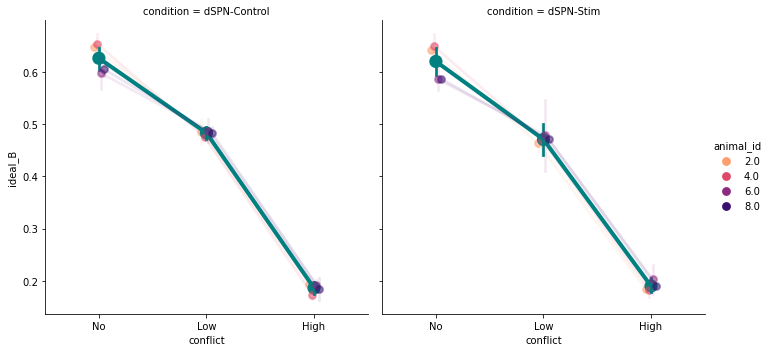

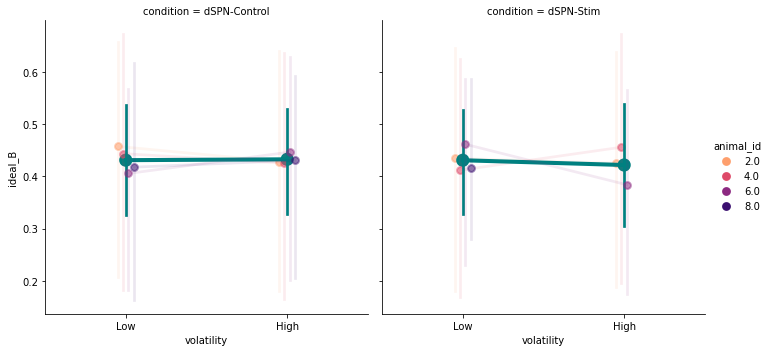

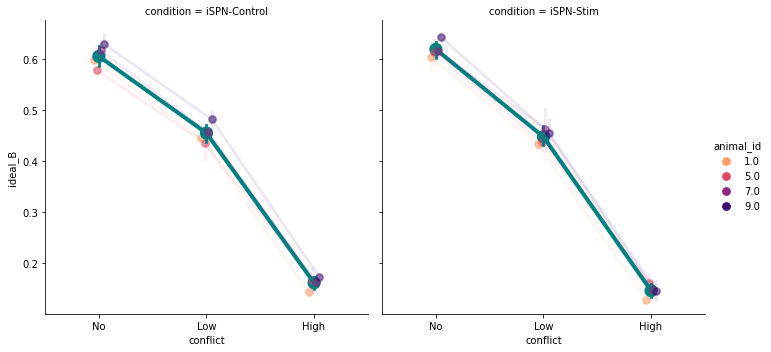

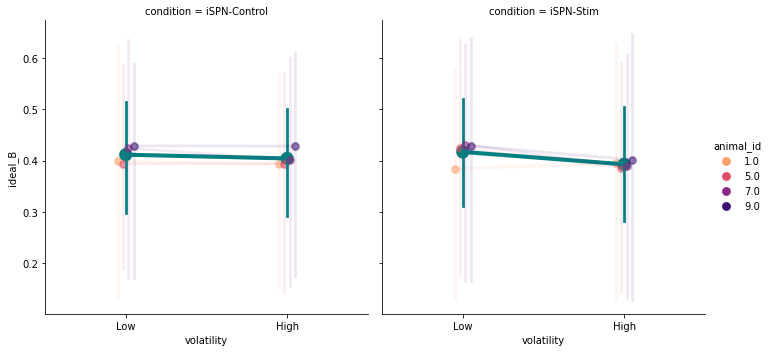

In [130]:
pointplots("ideal_B",mean_animal_avg_b,"avg")

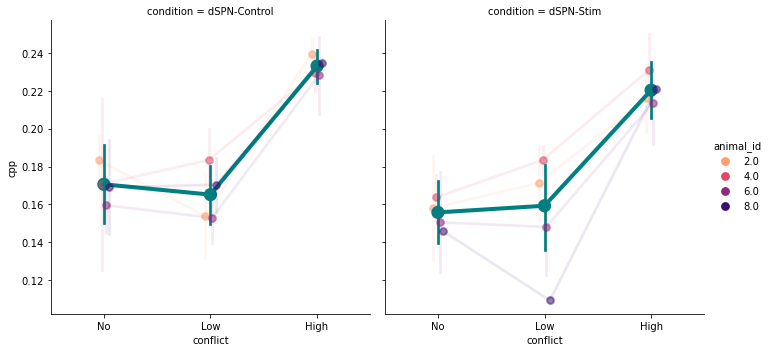

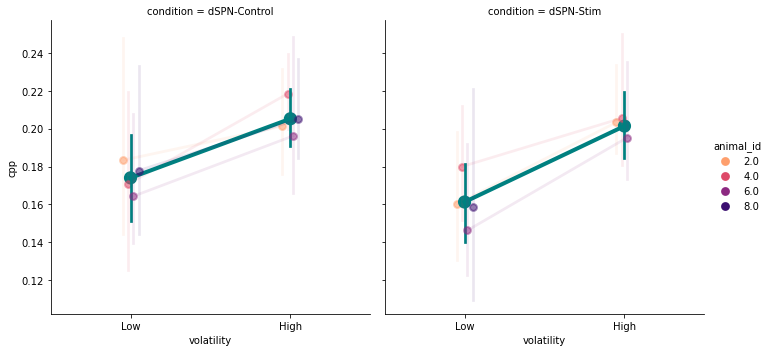

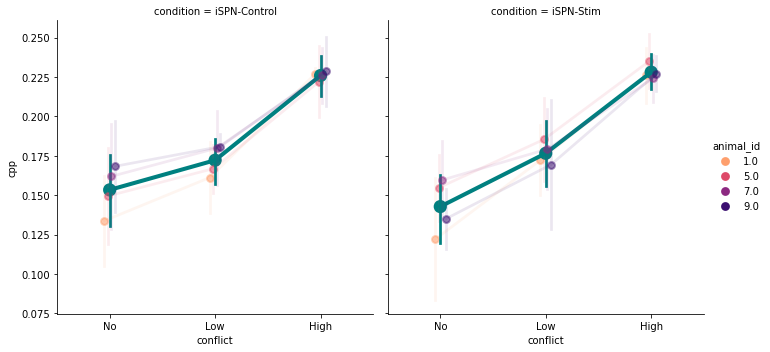

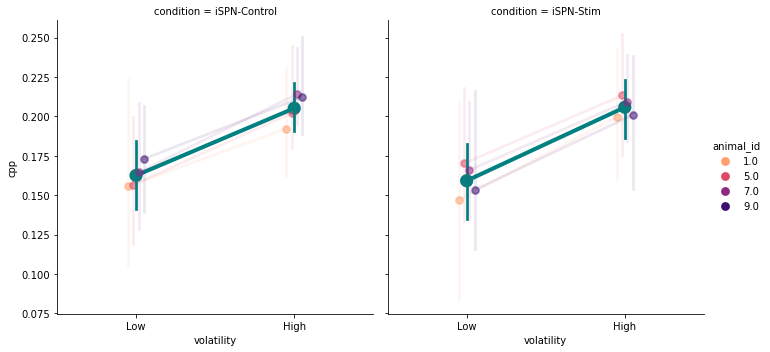

In [131]:
pointplots("cpp",mean_animal_avg_cpp,"avg")

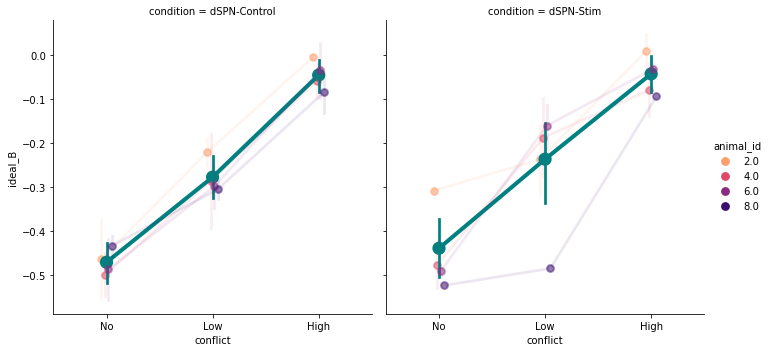

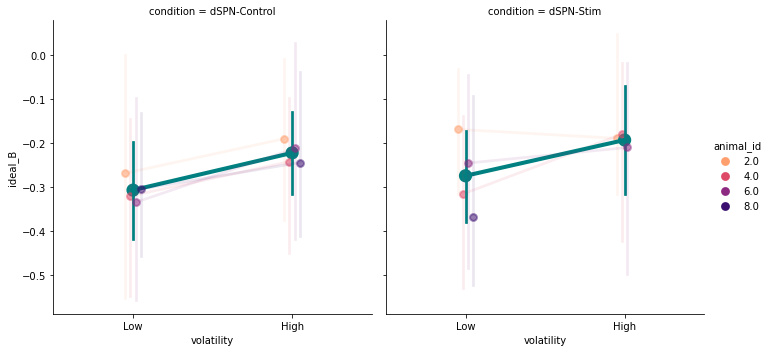

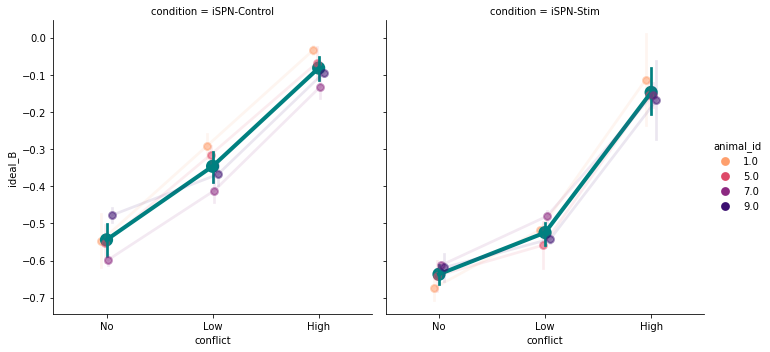

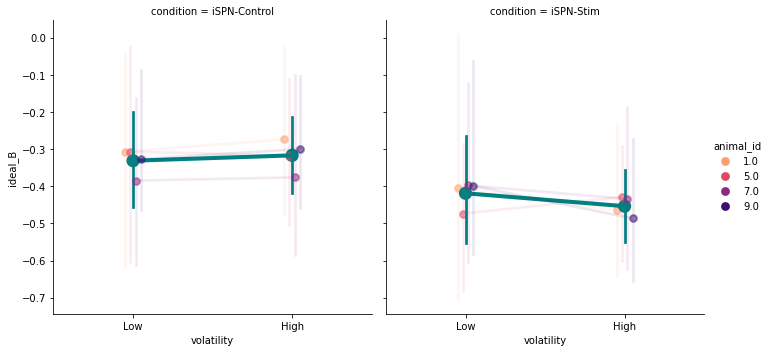

In [132]:
pointplots("ideal_B",mean_animal_cp_b,"cp")

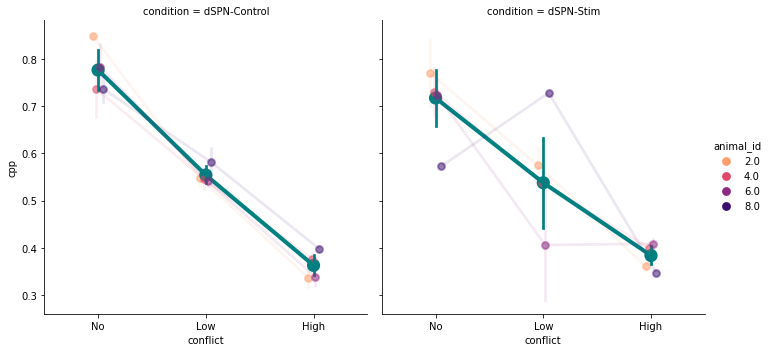

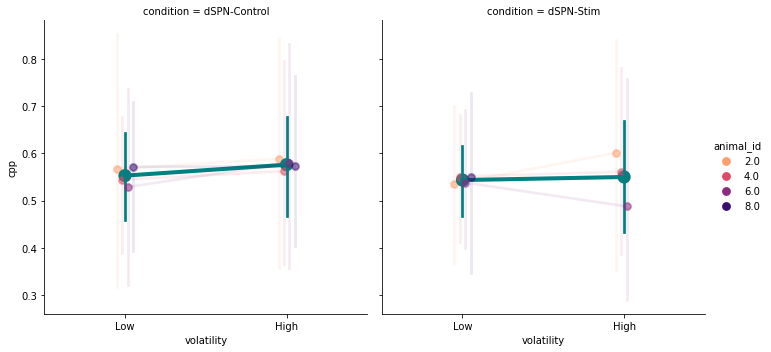

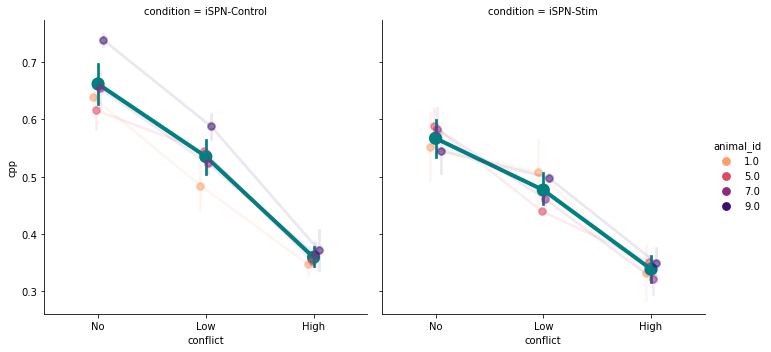

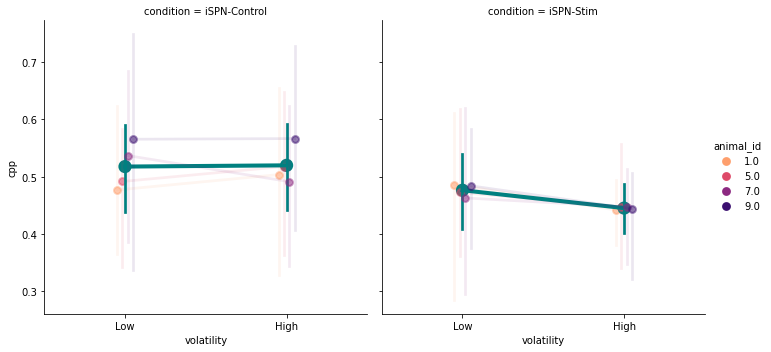

In [133]:
pointplots("cpp",mean_animal_cp_cpp,"cp")

In [288]:




def animal_wise_plots(block_change_aligned_df,dat_type,y_var,ispn_pairs,dspn_pairs,hue="condition",hue_order=[]):
    
    sns.set(font_scale=3)
    plt.rcParams["figure.facecolor"] = "w"
    sns.set_style(style='white')
    if dat_type == "avg":
        data = block_change_aligned_df.loc[block_change_aligned_df["trials_from_change_point"]>2]
    elif dat_type == "cp":
        data = block_change_aligned_df.loc[block_change_aligned_df["trials_from_change_point"]==0]
    
    print(hue)
    print(hue_order)
    # g1 = sns.catplot(x="conflict + volatility",y="ideal_B",data=data,hue="condition",col="animal_id",kind='bar',order=x_ticklabels,hue_order=hue_order,palette='tab10',col_wrap=3,height=15,aspect=1.0)
    g1 = sns.catplot(x="conflict + volatility",y=y_var,data=data,hue=hue,col="animal_id",kind='point',order=x_ticklabels,hue_order=hue_order,palette='tab10',col_wrap=3,height=15,aspect=1.0,linewidth=4.0,marker='o',scale=3)
    for ax in g1.axes:
        an = float(ax.get_title().split(' = ')[1])
        if y_var == "ideal_B":
            ylab = r'$\Delta$'+"B"+"("+dat_type+")"
        elif y_var == "cpp":
            ylab = r'$\Omega$'+"("+dat_type+")"
        elif y_var == "rt":
            ylab = "RT"+"("+dat_type+")"
        elif y_var == "response":
            ylab = "Accuracy"
        elif y_var == "B_over_CPP":
            ylab = "B/CPP"
        elif y_var == "CPP_over_B":
            ylab = "CPP/B"
            
        ax.set_ylabel(ylab,fontsize=40)
        
        df = data.loc[data["animal_id"]==an]
        xlims = ax.get_xlim()
    #     ax.hlines(y=0.5,xmin=xlims[0],xmax=xlims[1],ls='dashed',color='k')
        ax.set_xlim(xlims[0],xlims[1])
        ax.set_ylabel(ax.get_ylabel(),fontsize=30)
        
        if float(an)%2 == 0:
            bp = dspn_pairs
        else:
            bp = ispn_pairs

        for x in ax.get_xticklabels():
            x.set_rotation(45)


        x_ticks = ax.get_xticks()
        ylims = ax.get_ylim()
        if len(bp) > 0:
            for i,x in enumerate(bp):
                sub_dat1 = df.loc[(df["conflict + volatility"]==x[0][0])&(df["condition"]==x[0][1])][y_var].values
                sub_dat2 = df.loc[(df["conflict + volatility"]==x[1][0])&(df["condition"]==x[1][1])][y_var].values
                #print(x)
                t,p = sp_st.ttest_ind(sub_dat1,sub_dat2)
                #print(t,p)
                if p < 0.05:

                    if p < 0.05 and p > 0.01:
                        sym = "*"
                    elif p < 0.01 and p > 0.001:
                        sym = "**"
                    elif p < 0.001 and p > 0.0001:
                        sym = "***"
                    elif p < 0.0001:
                        sym = "****"

                    #print(t,p)
                    y = np.max([np.mean(sub_dat1),np.mean(sub_dat2)])*1.1
                    if y < 0:
                        y = np.min([np.mean(sub_dat1),np.mean(sub_dat2)])*1.1

                    print(y)
                    ax.text(x_ticks[i]-0.1,y,sym,color='k',fontsize=45,fontweight='bold')
    g1.fig.subplots_adjust(bottom=0.1)
    g1.fig.savefig(fig_target_dir+"animal_wise_plots_"+y_var+"_"+dat_type+".png")

# Not significant        
#     add_stat_annotation(ax, data=df, x="conflict + volatility", y="ideal_B", order=x_ticklabels,hue="condition",hue_order=hue_order,
#                                    box_pairs=bp,
                        
#                                    test='t-test_ind', text_format='star',
#                                    loc='inside', verbose=2)

    #add_stat_annotation(ax, data=df, x="conflict + volatility", y="ideal_B", order=x_ticklabels,hue="condition",hue_order=hue_order,box_pairs=bp,test='t-test_ind', text_format='star',loc='inside', verbose=2)




0.688542952178295
0.6915597623611396
0.7392443197376984
0.7402239448869612
0.703476790496759
0.4983975079810024
0.5136787131237825
0.690549931160396
0.600989846689175
0.5600061922912686
0.7116094811008711
0.5492608088372262


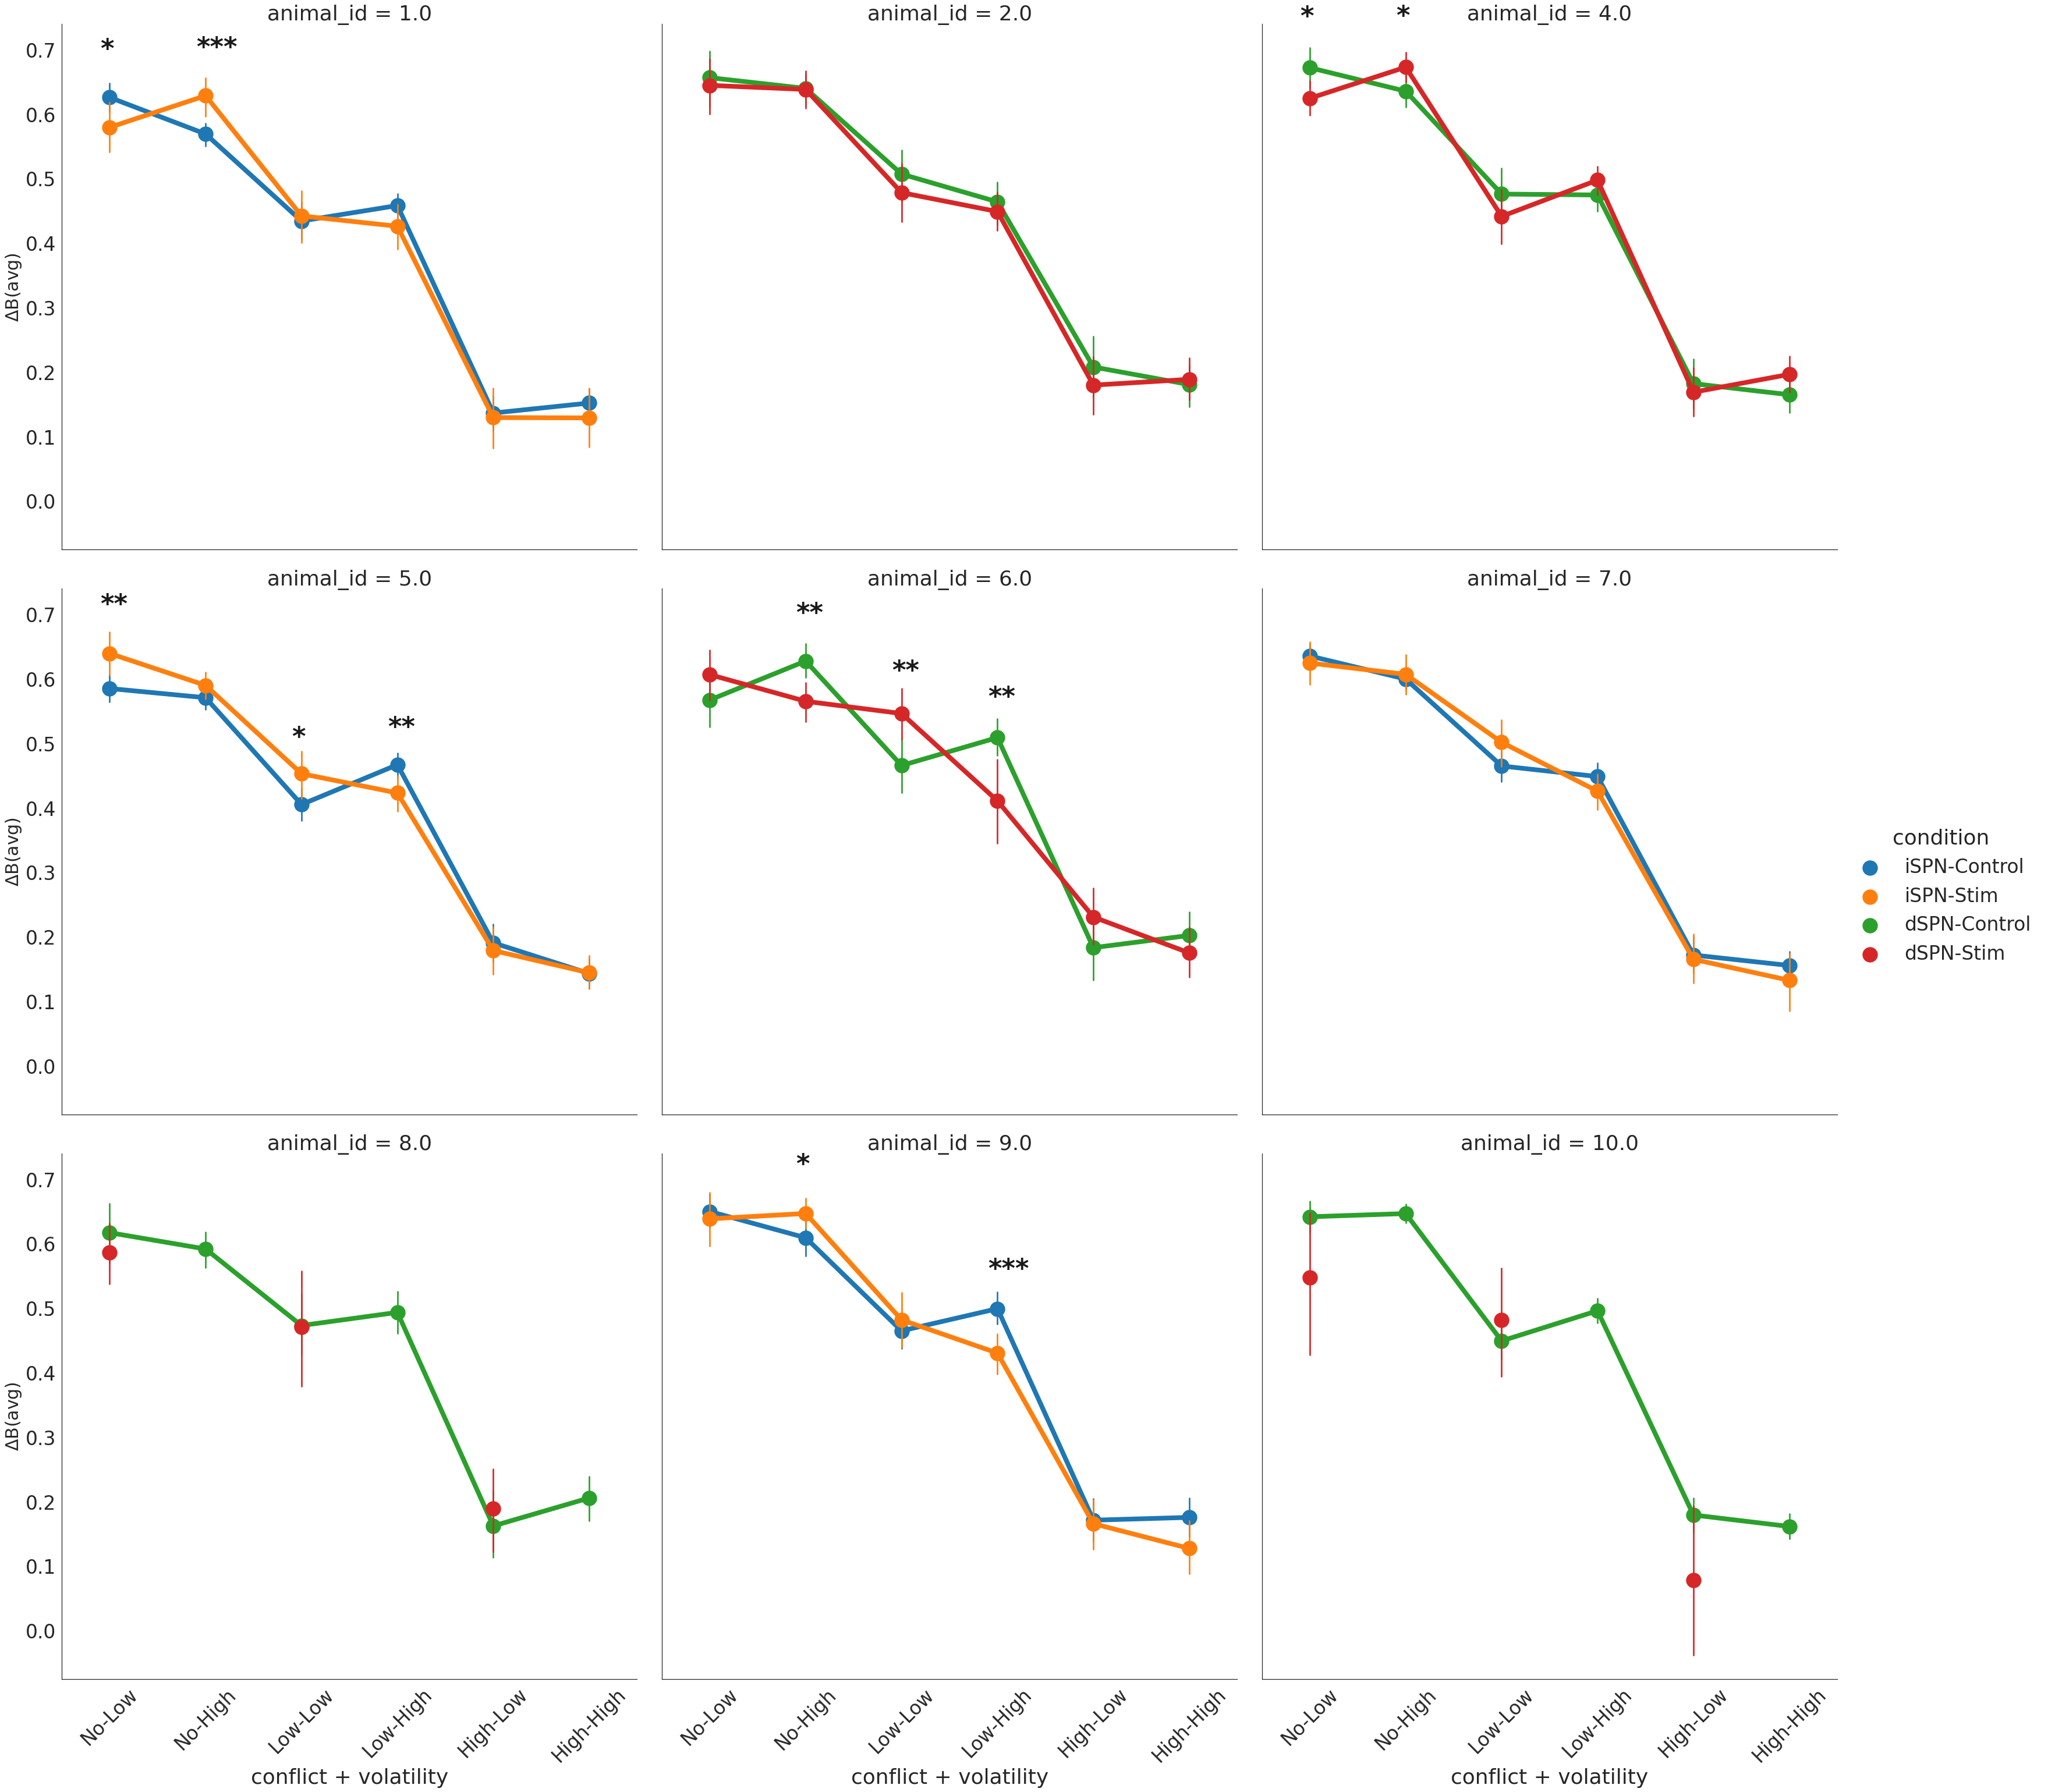

In [278]:
animal_wise_plots(block_change_aligned_df,"avg","ideal_B",ispn_pairs,dspn_pairs,"condition",hue_order)

0.7130063965884862
0.7766891891891892
0.7492165898617512
0.7142412105028928
0.683980181668043
0.69120082815735
0.9498933901918978
0.7957875457875458
0.8329752953813104
0.7974164133738603
0.7582766439909298
0.7666435506241333
0.7109142857142857
0.7841323106423778
0.7376757957068838
0.7274760383386583
0.6347098214285715
0.8881987577639752
0.9128151260504203
0.7882086167800455
0.7390269151138716
0.6859410430839002
0.6626684636118599
0.6744571428571429
0.659153122326775
0.8283292978208233
0.7989795918367347
0.7999078341013826
0.7420118343195267
0.7905494505494506
0.6691244239631338
0.6761389961389962
0.8642857142857143
0.8743589743589744
0.7432432432432433


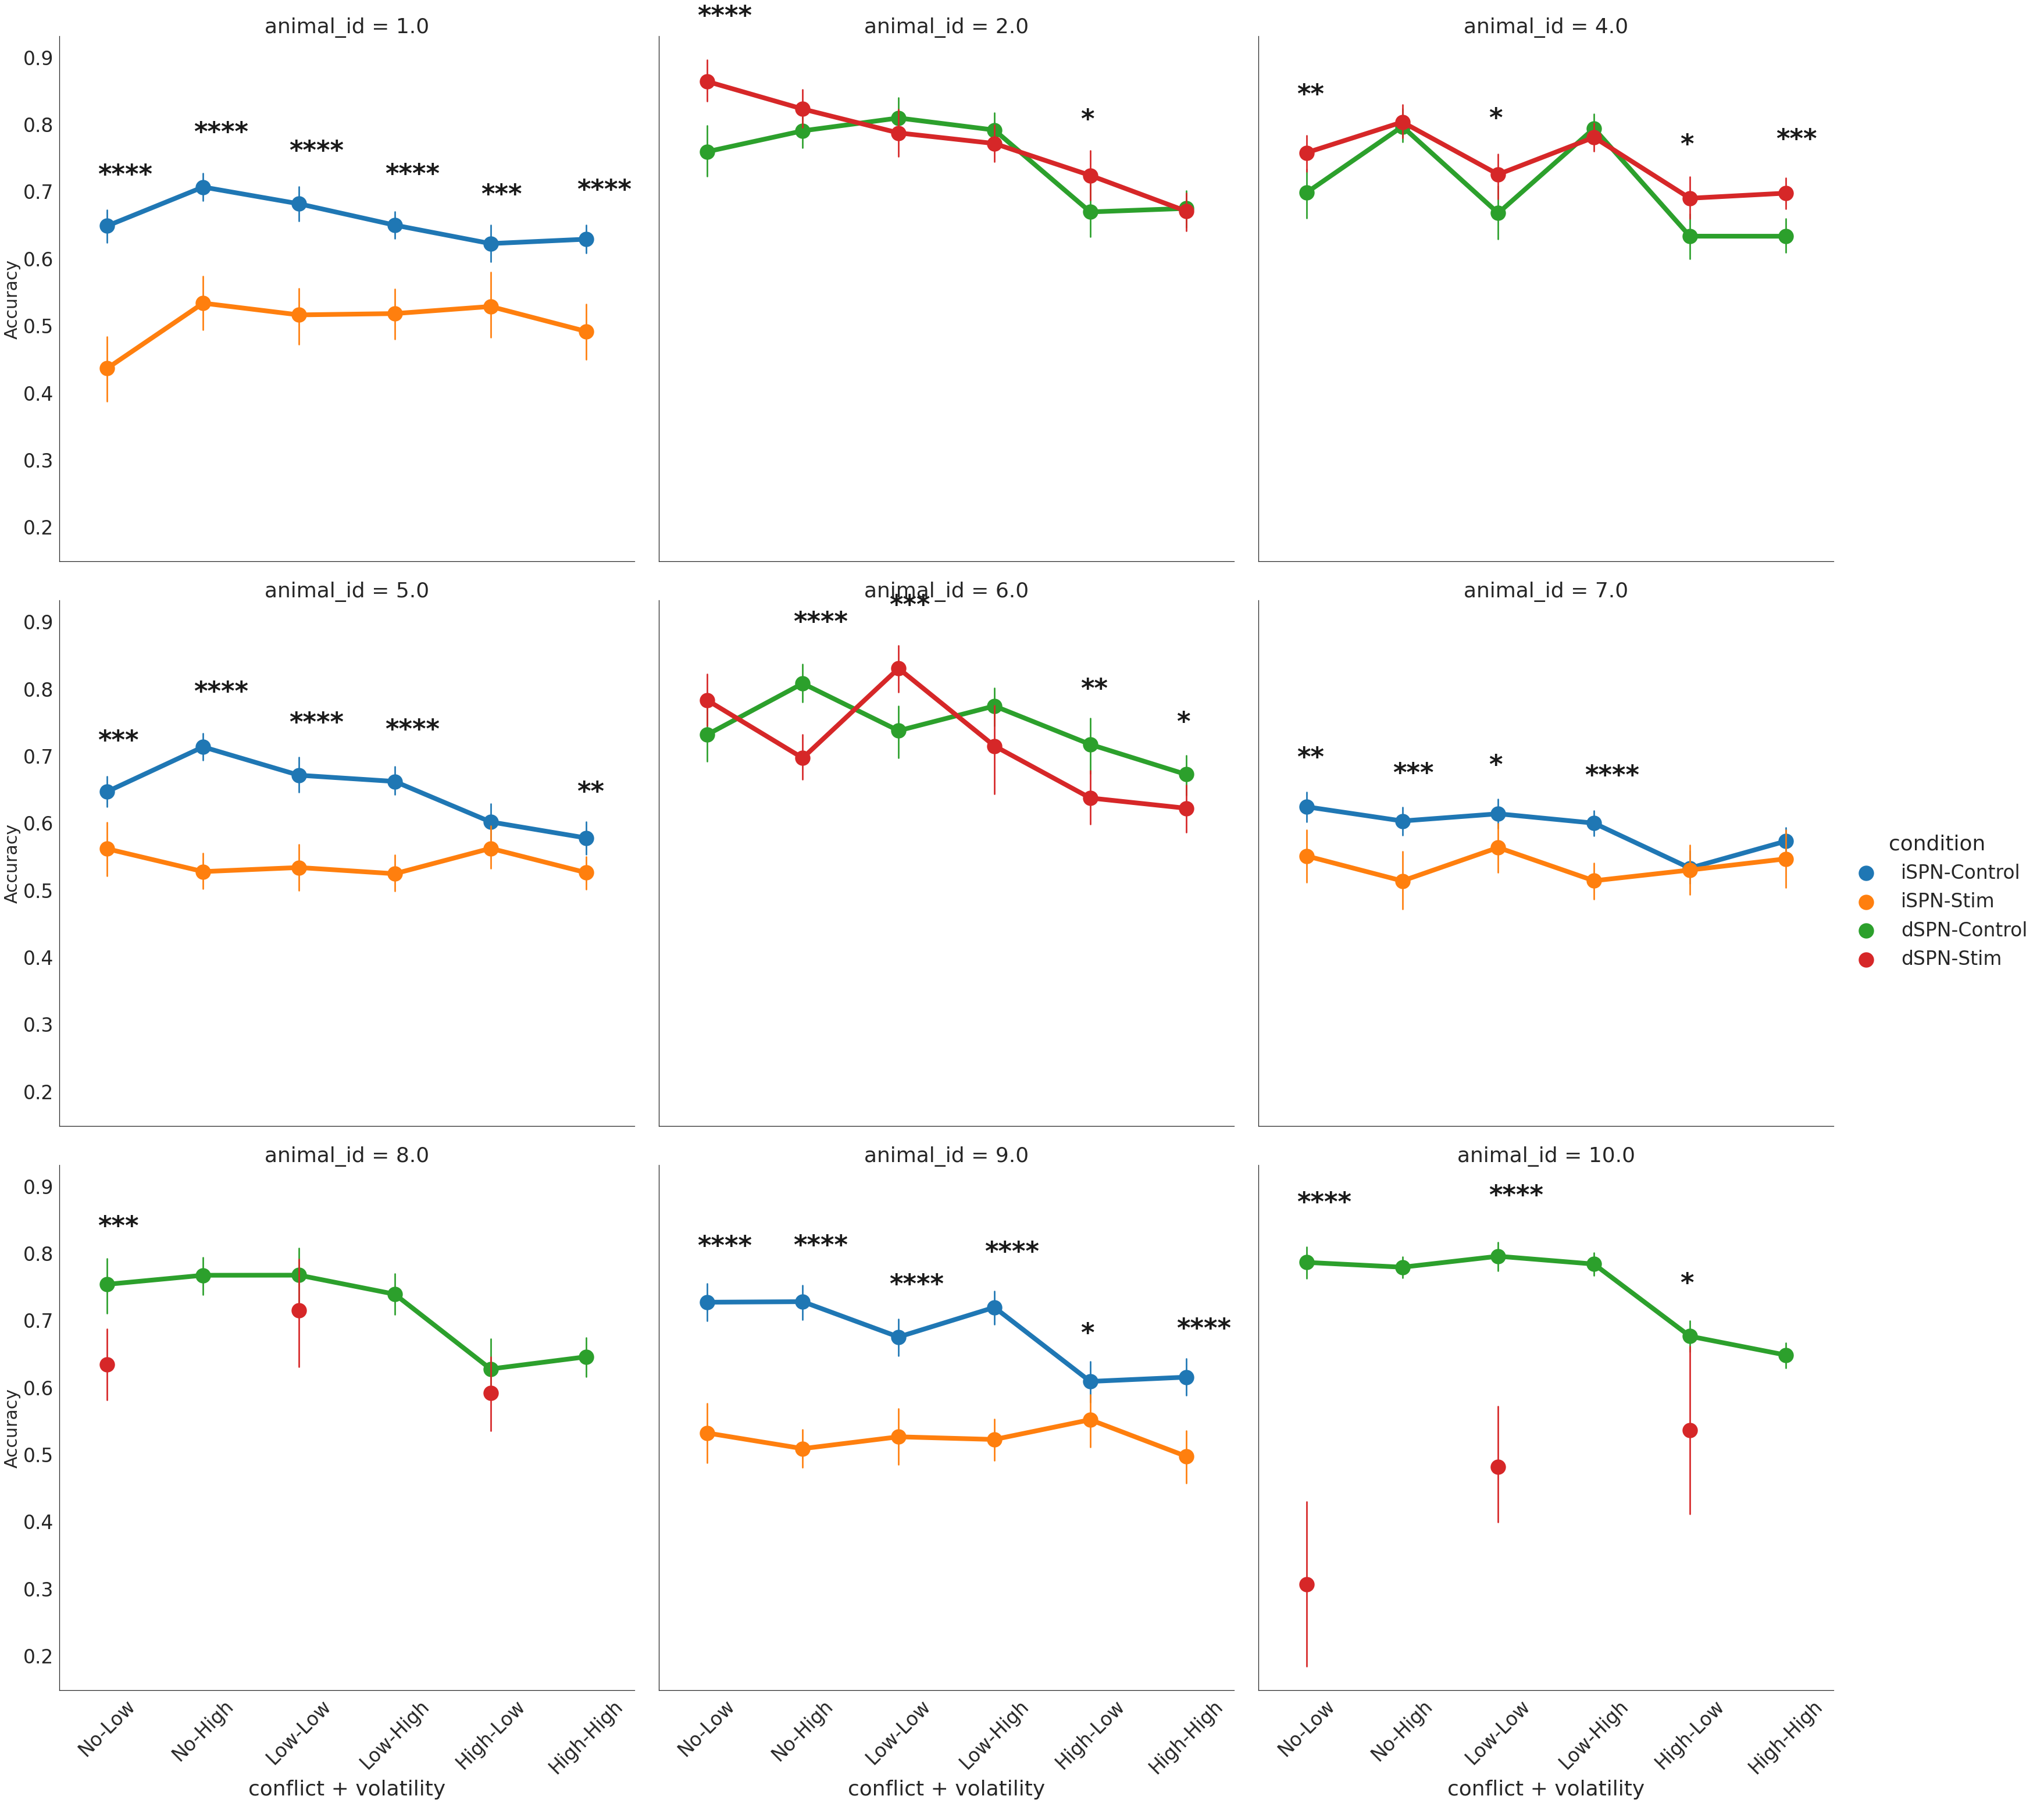

In [279]:
animal_wise_plots(block_change_aligned_df,"avg","response",ispn_pairs,dspn_pairs,"condition",hue_order)

14.766342339261895
11.440386722825115
24.10041656698278
13.099386082312025
12.682535429084346
10.348277651328594
10.375617147034887
3.618865001918843


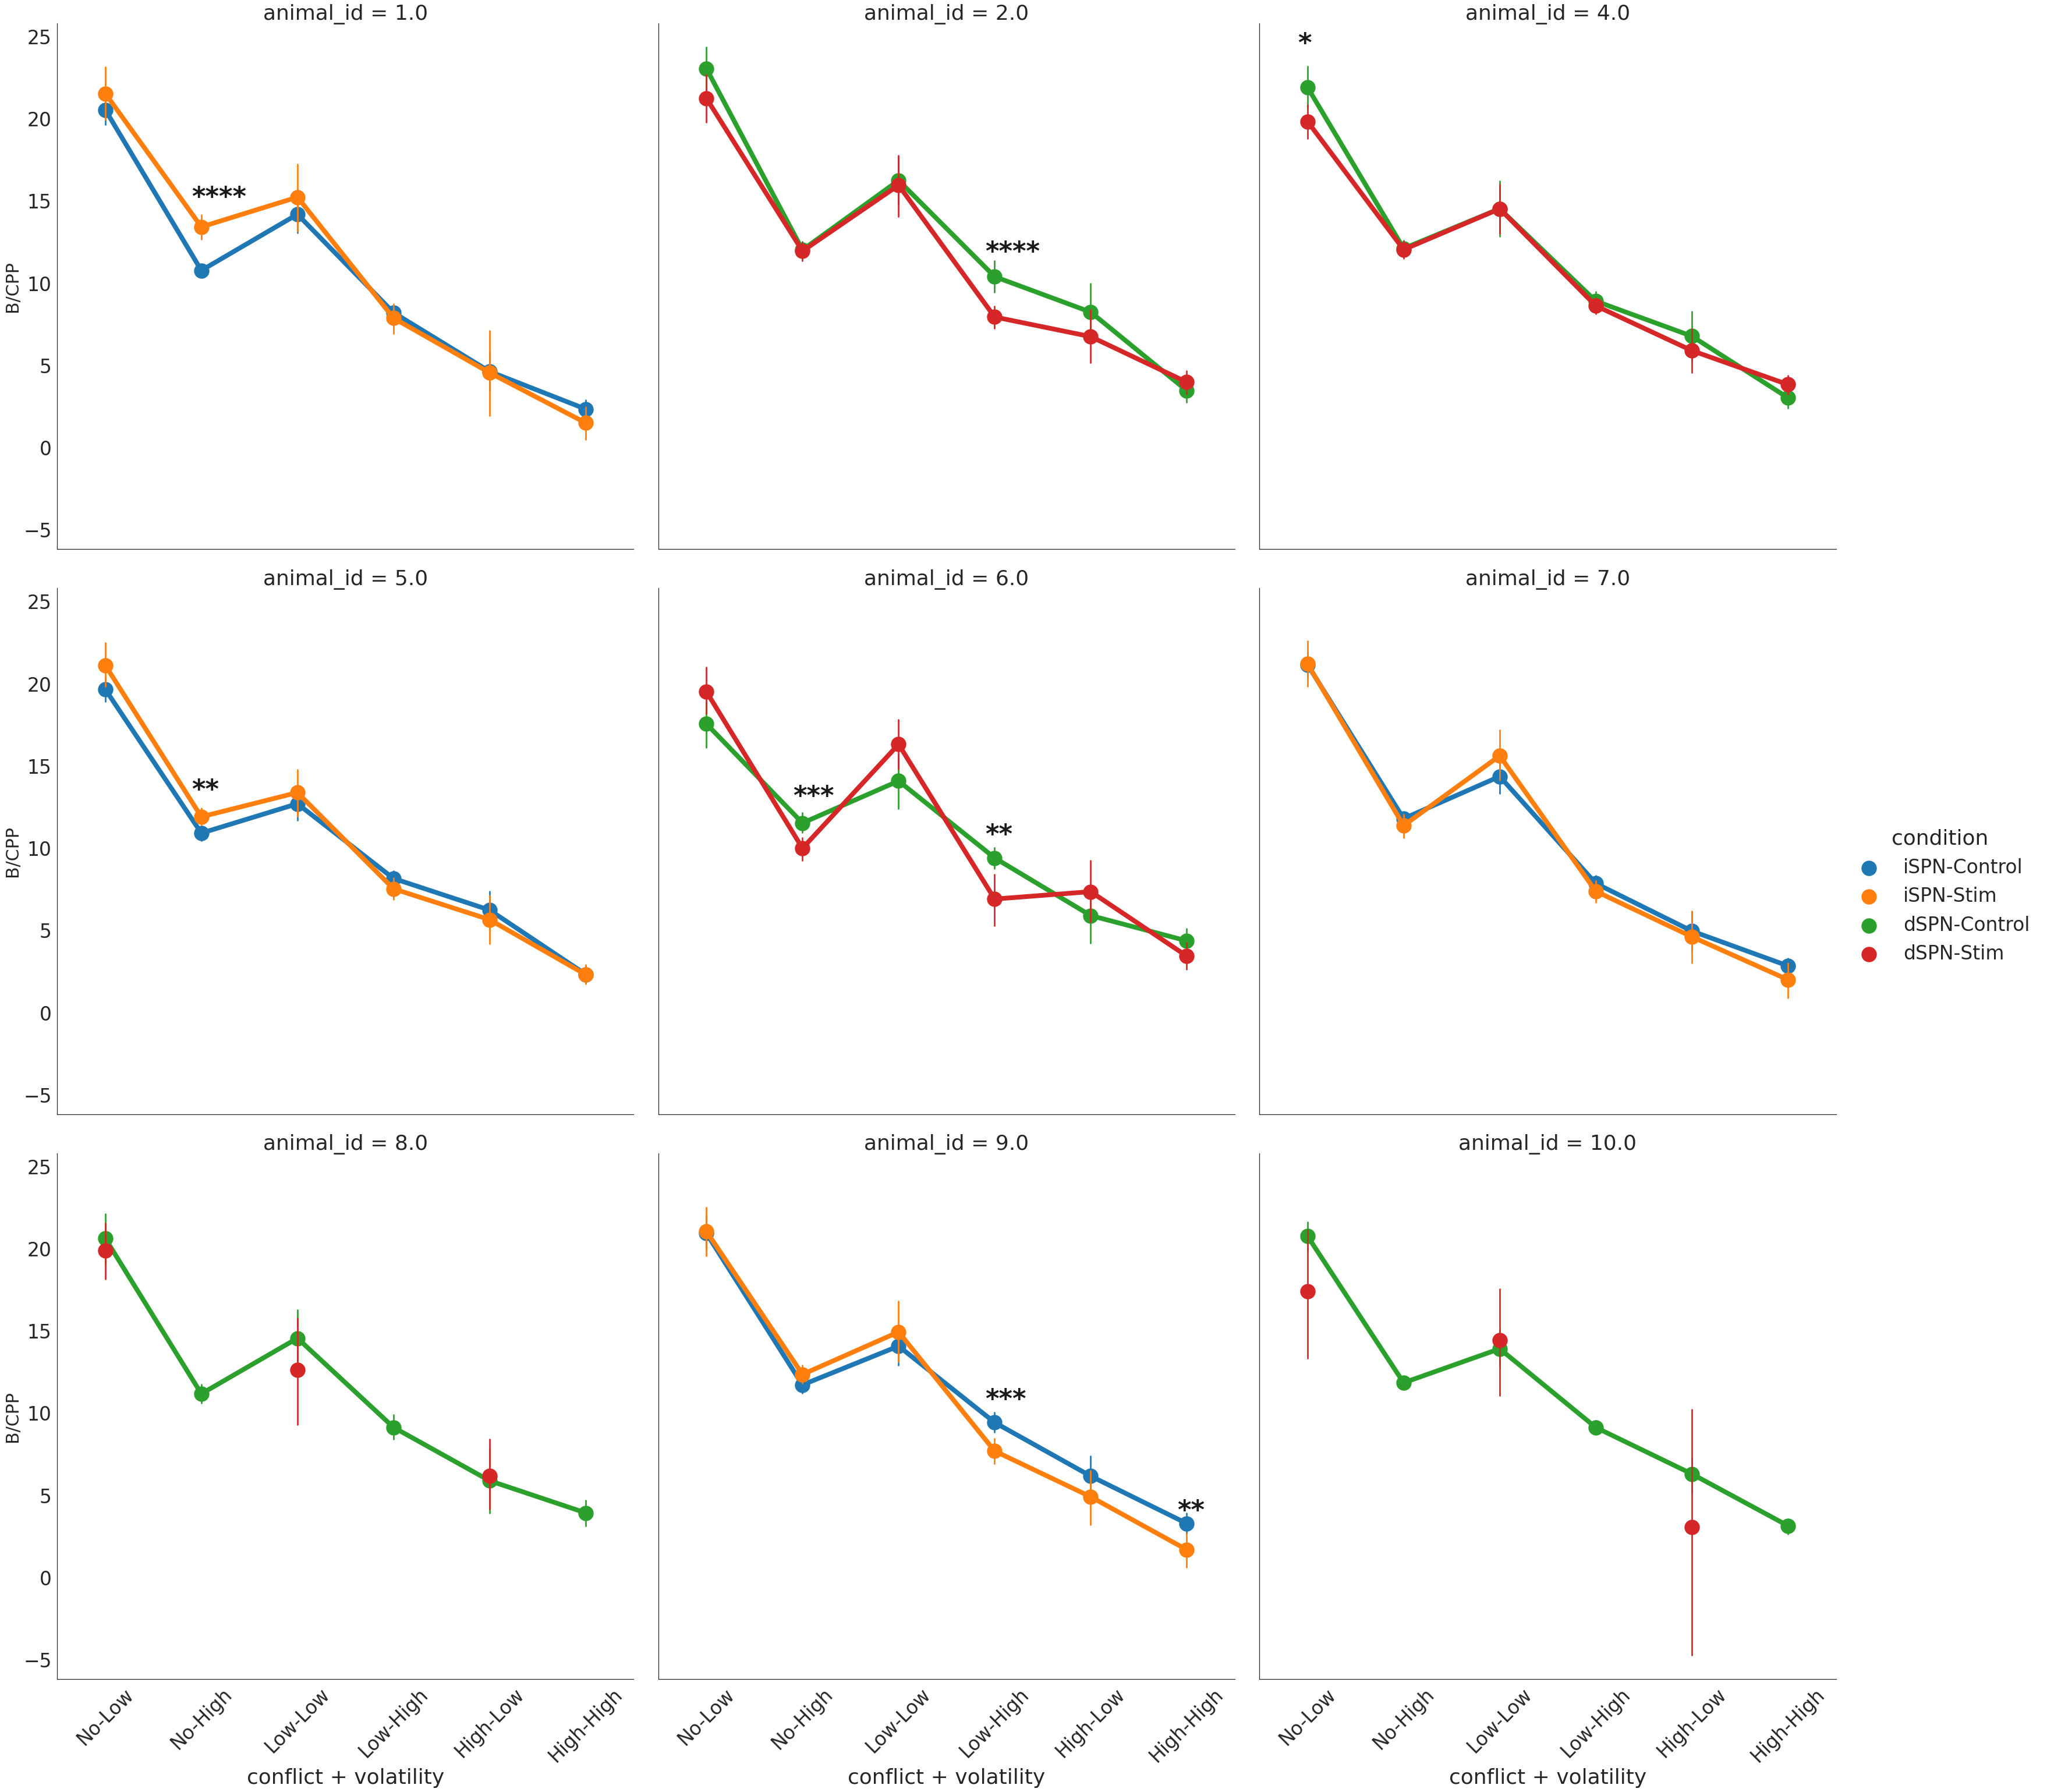

In [280]:
animal_wise_plots(block_change_aligned_df,"avg","B_over_CPP",ispn_pairs,dspn_pairs,"condition",hue_order)

0.1877176469935565
0.27245680142303086
0.23741148654871827
0.23298545825766837
0.21671035450886267
0.19006765992736052
0.14076413643721292


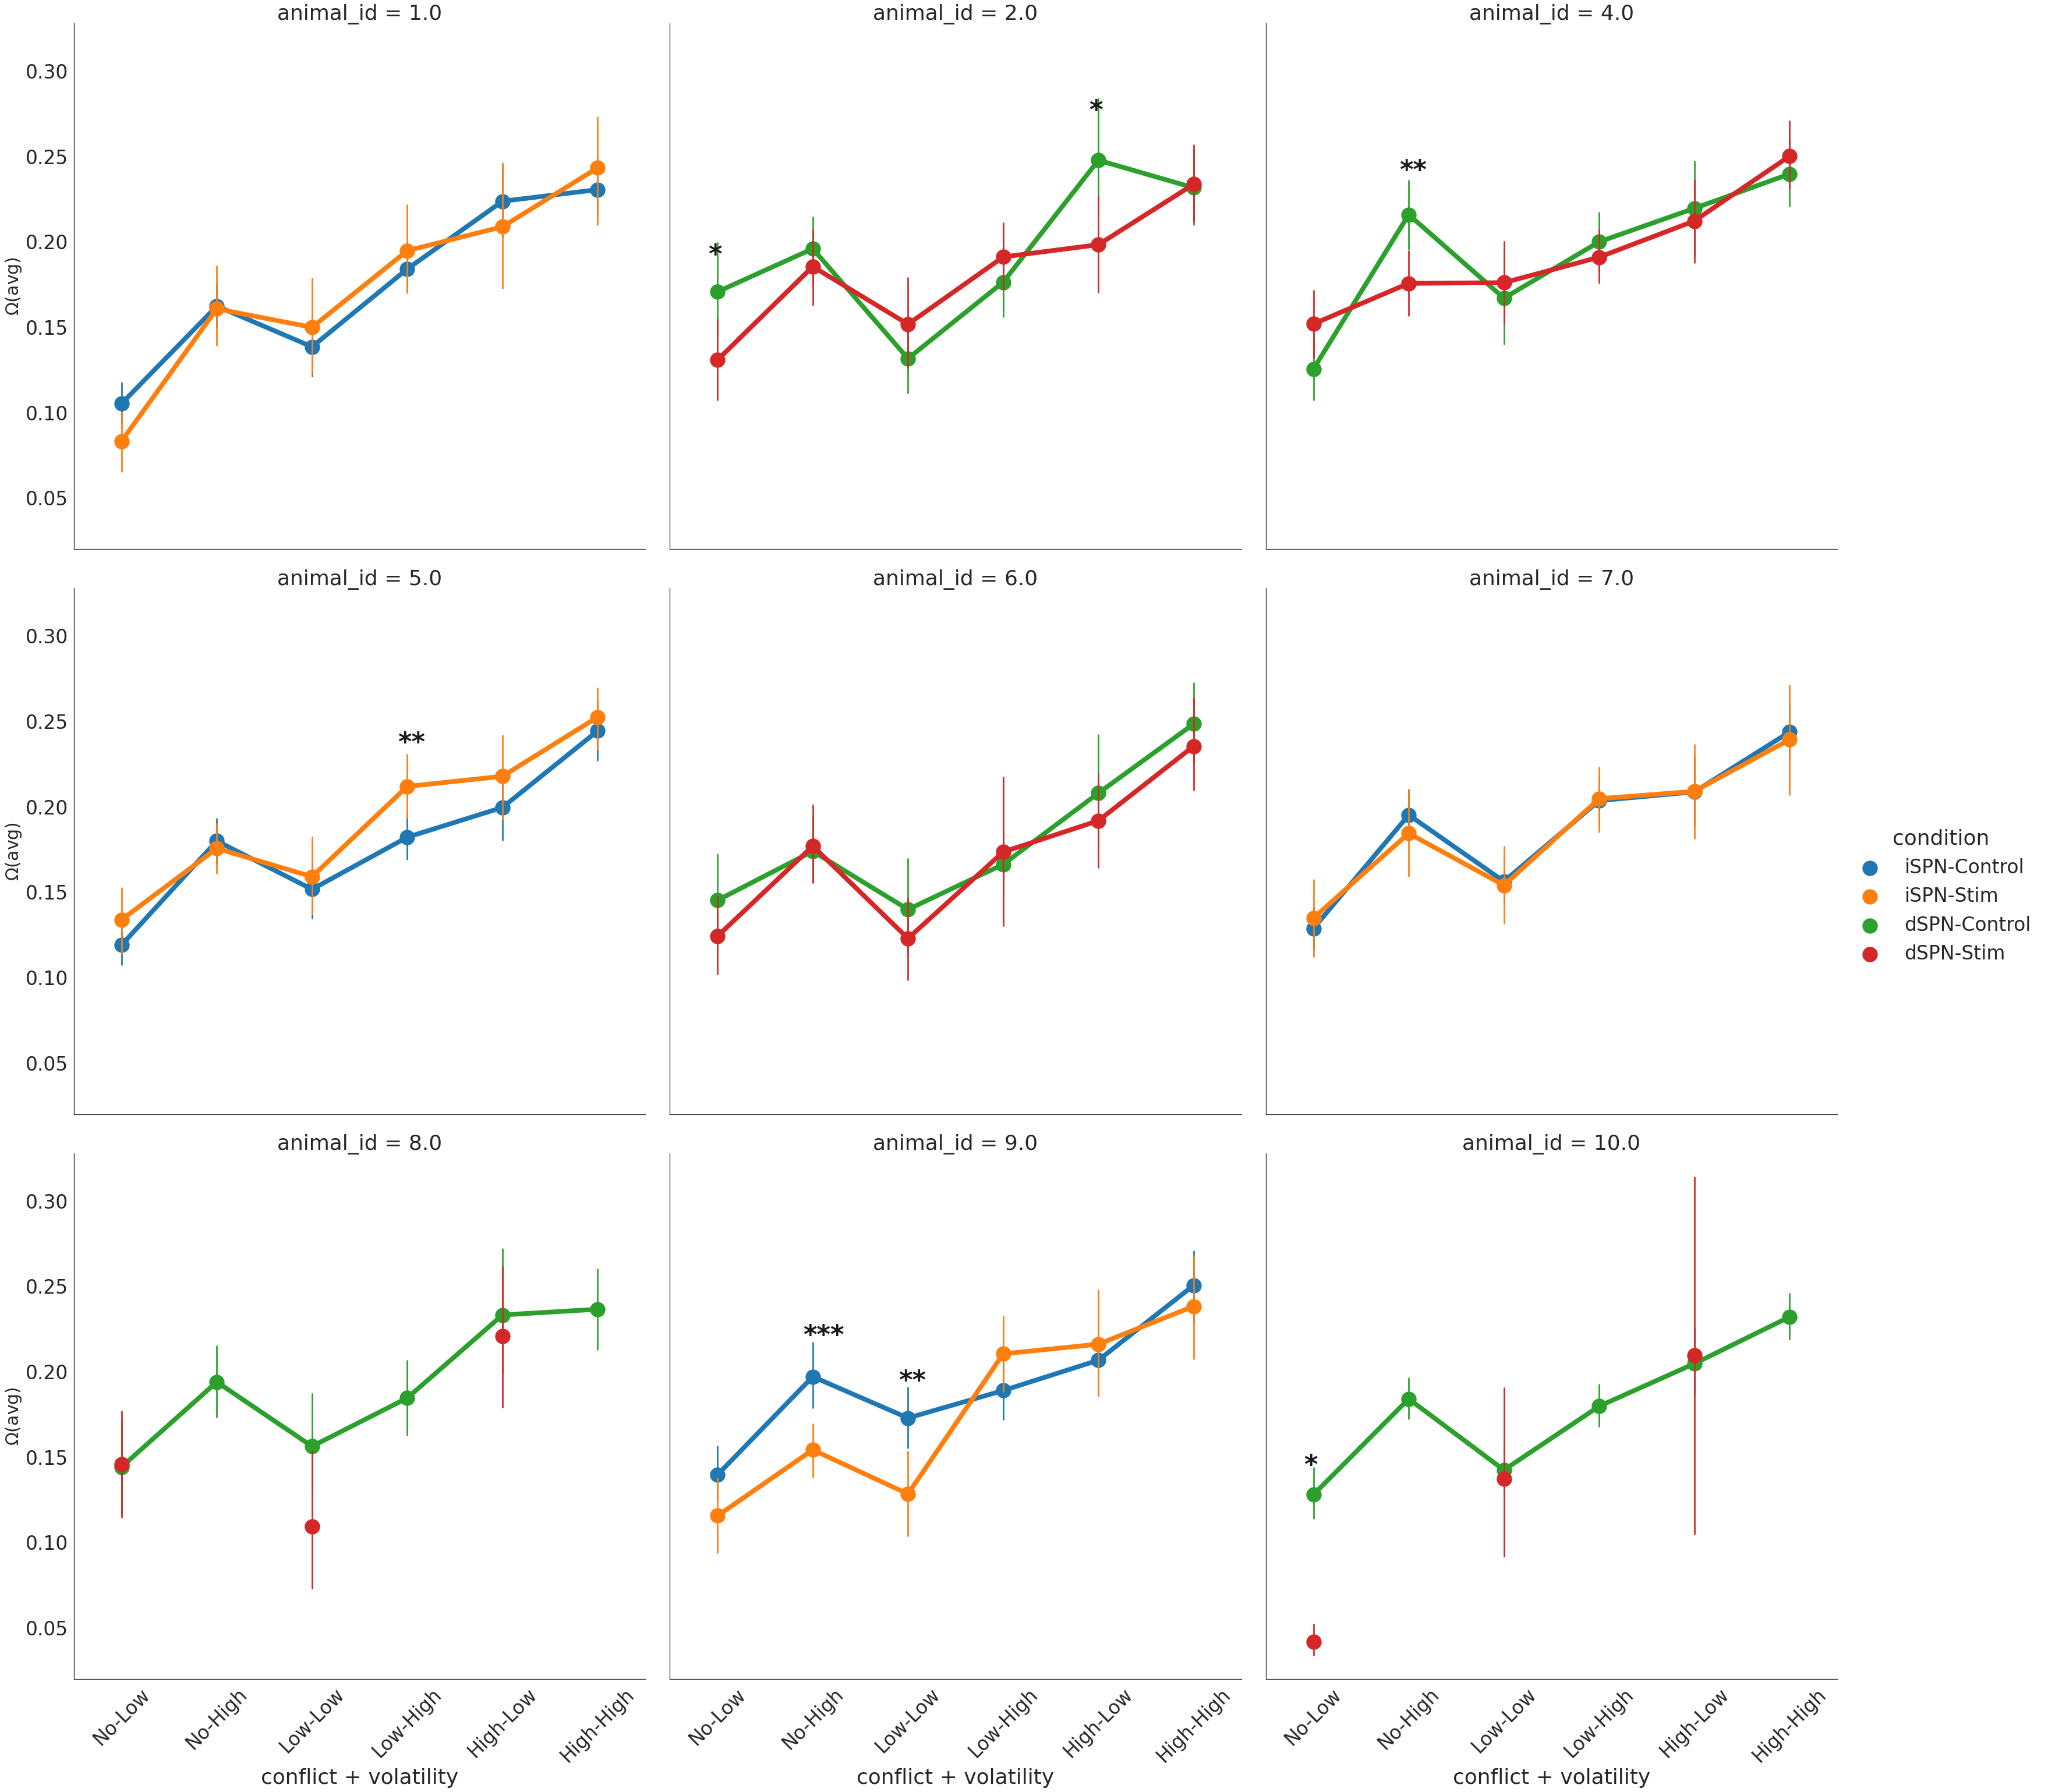

In [281]:
animal_wise_plots(block_change_aligned_df,"avg","cpp",ispn_pairs,dspn_pairs,"condition",hue_order)

In [282]:
animal_wise_plots(block_change_aligned_df,"cp","response",ispn_pairs,dspn_pairs,,"condition",hue_order)

SyntaxError: invalid syntax (2847879663.py, line 1)

condition + bias
['dSPN-Control - left->right', 'dSPN-Control - right->left', 'dSPN-Stim - left->right', 'dSPN-Stim - right->left', 'iSPN-Control - left->right', 'iSPN-Control - right->left', 'iSPN-Stim - left->right', 'iSPN-Stim - right->left']


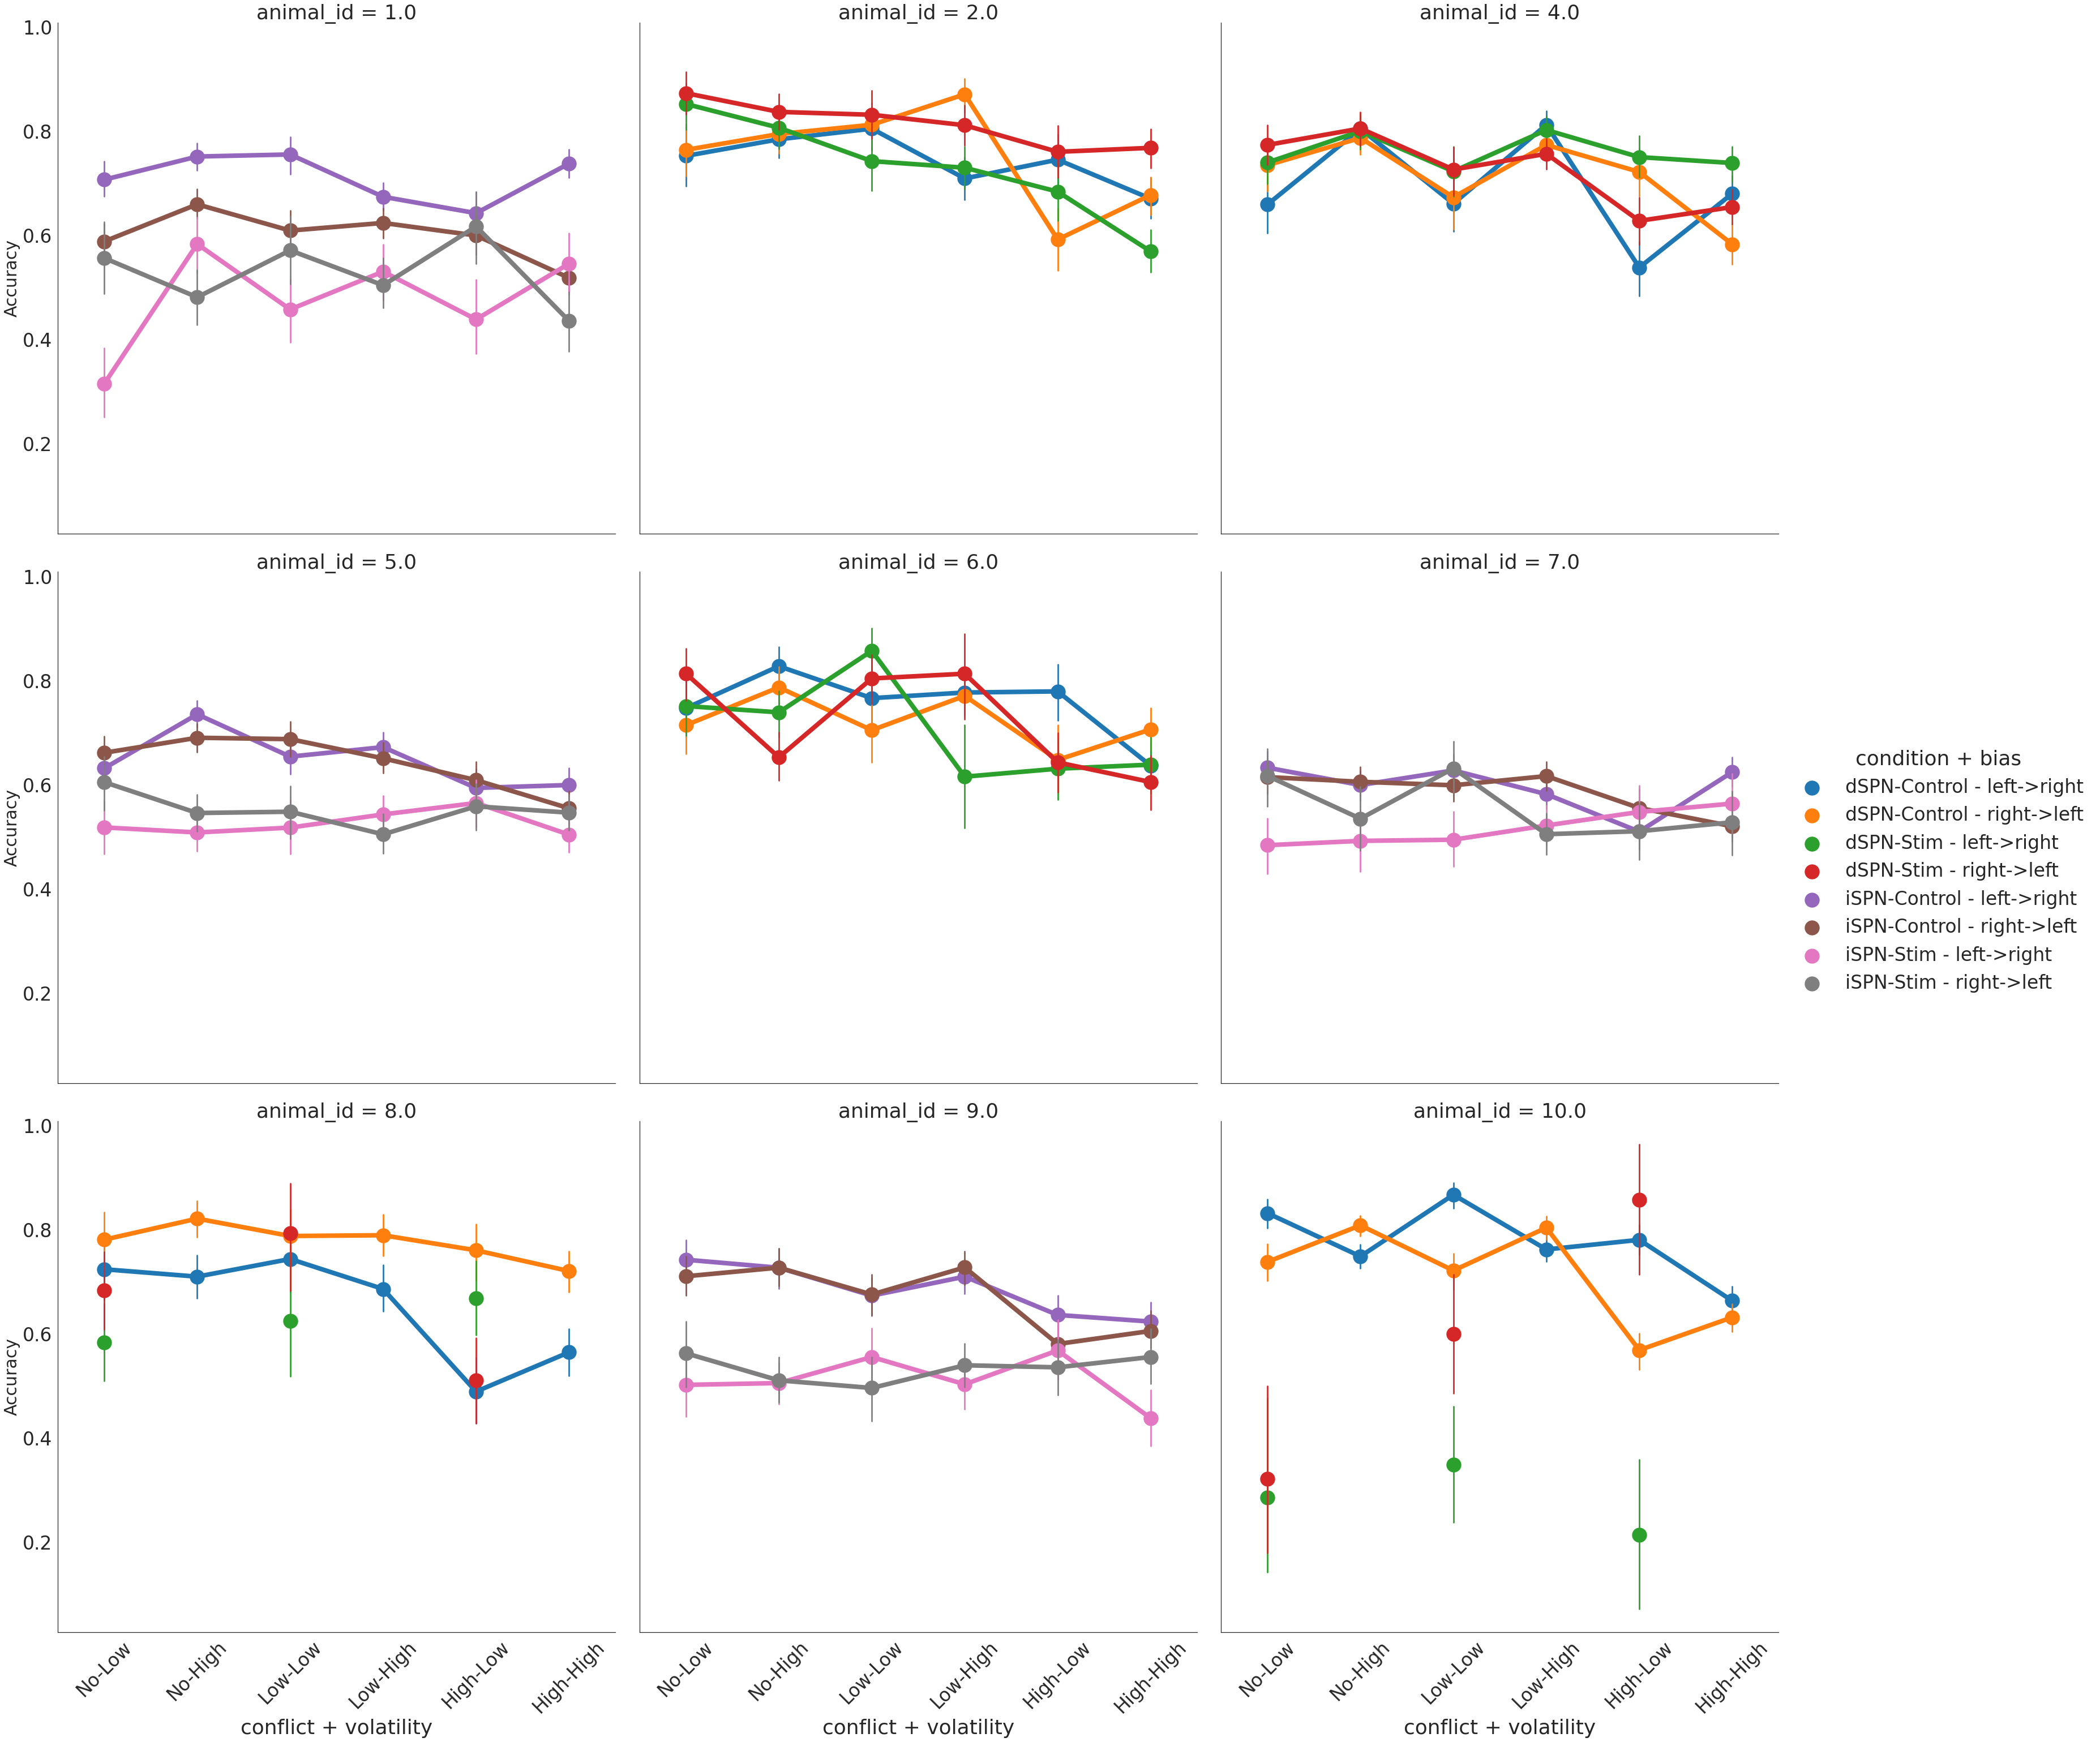

In [291]:
# Find animal bias
cond_bias = [ x+" - "+y for x in np.unique(block_change_aligned_df["condition"]) for y in np.unique(block_change_aligned_df["block_change_type"])]


animal_wise_plots(block_change_aligned_df,"avg","response",[],[],"condition + bias",cond_bias)

condition + bias
['dSPN-Control - left->right', 'dSPN-Control - right->left', 'dSPN-Stim - left->right', 'dSPN-Stim - right->left', 'iSPN-Control - left->right', 'iSPN-Control - right->left', 'iSPN-Stim - left->right', 'iSPN-Stim - right->left']


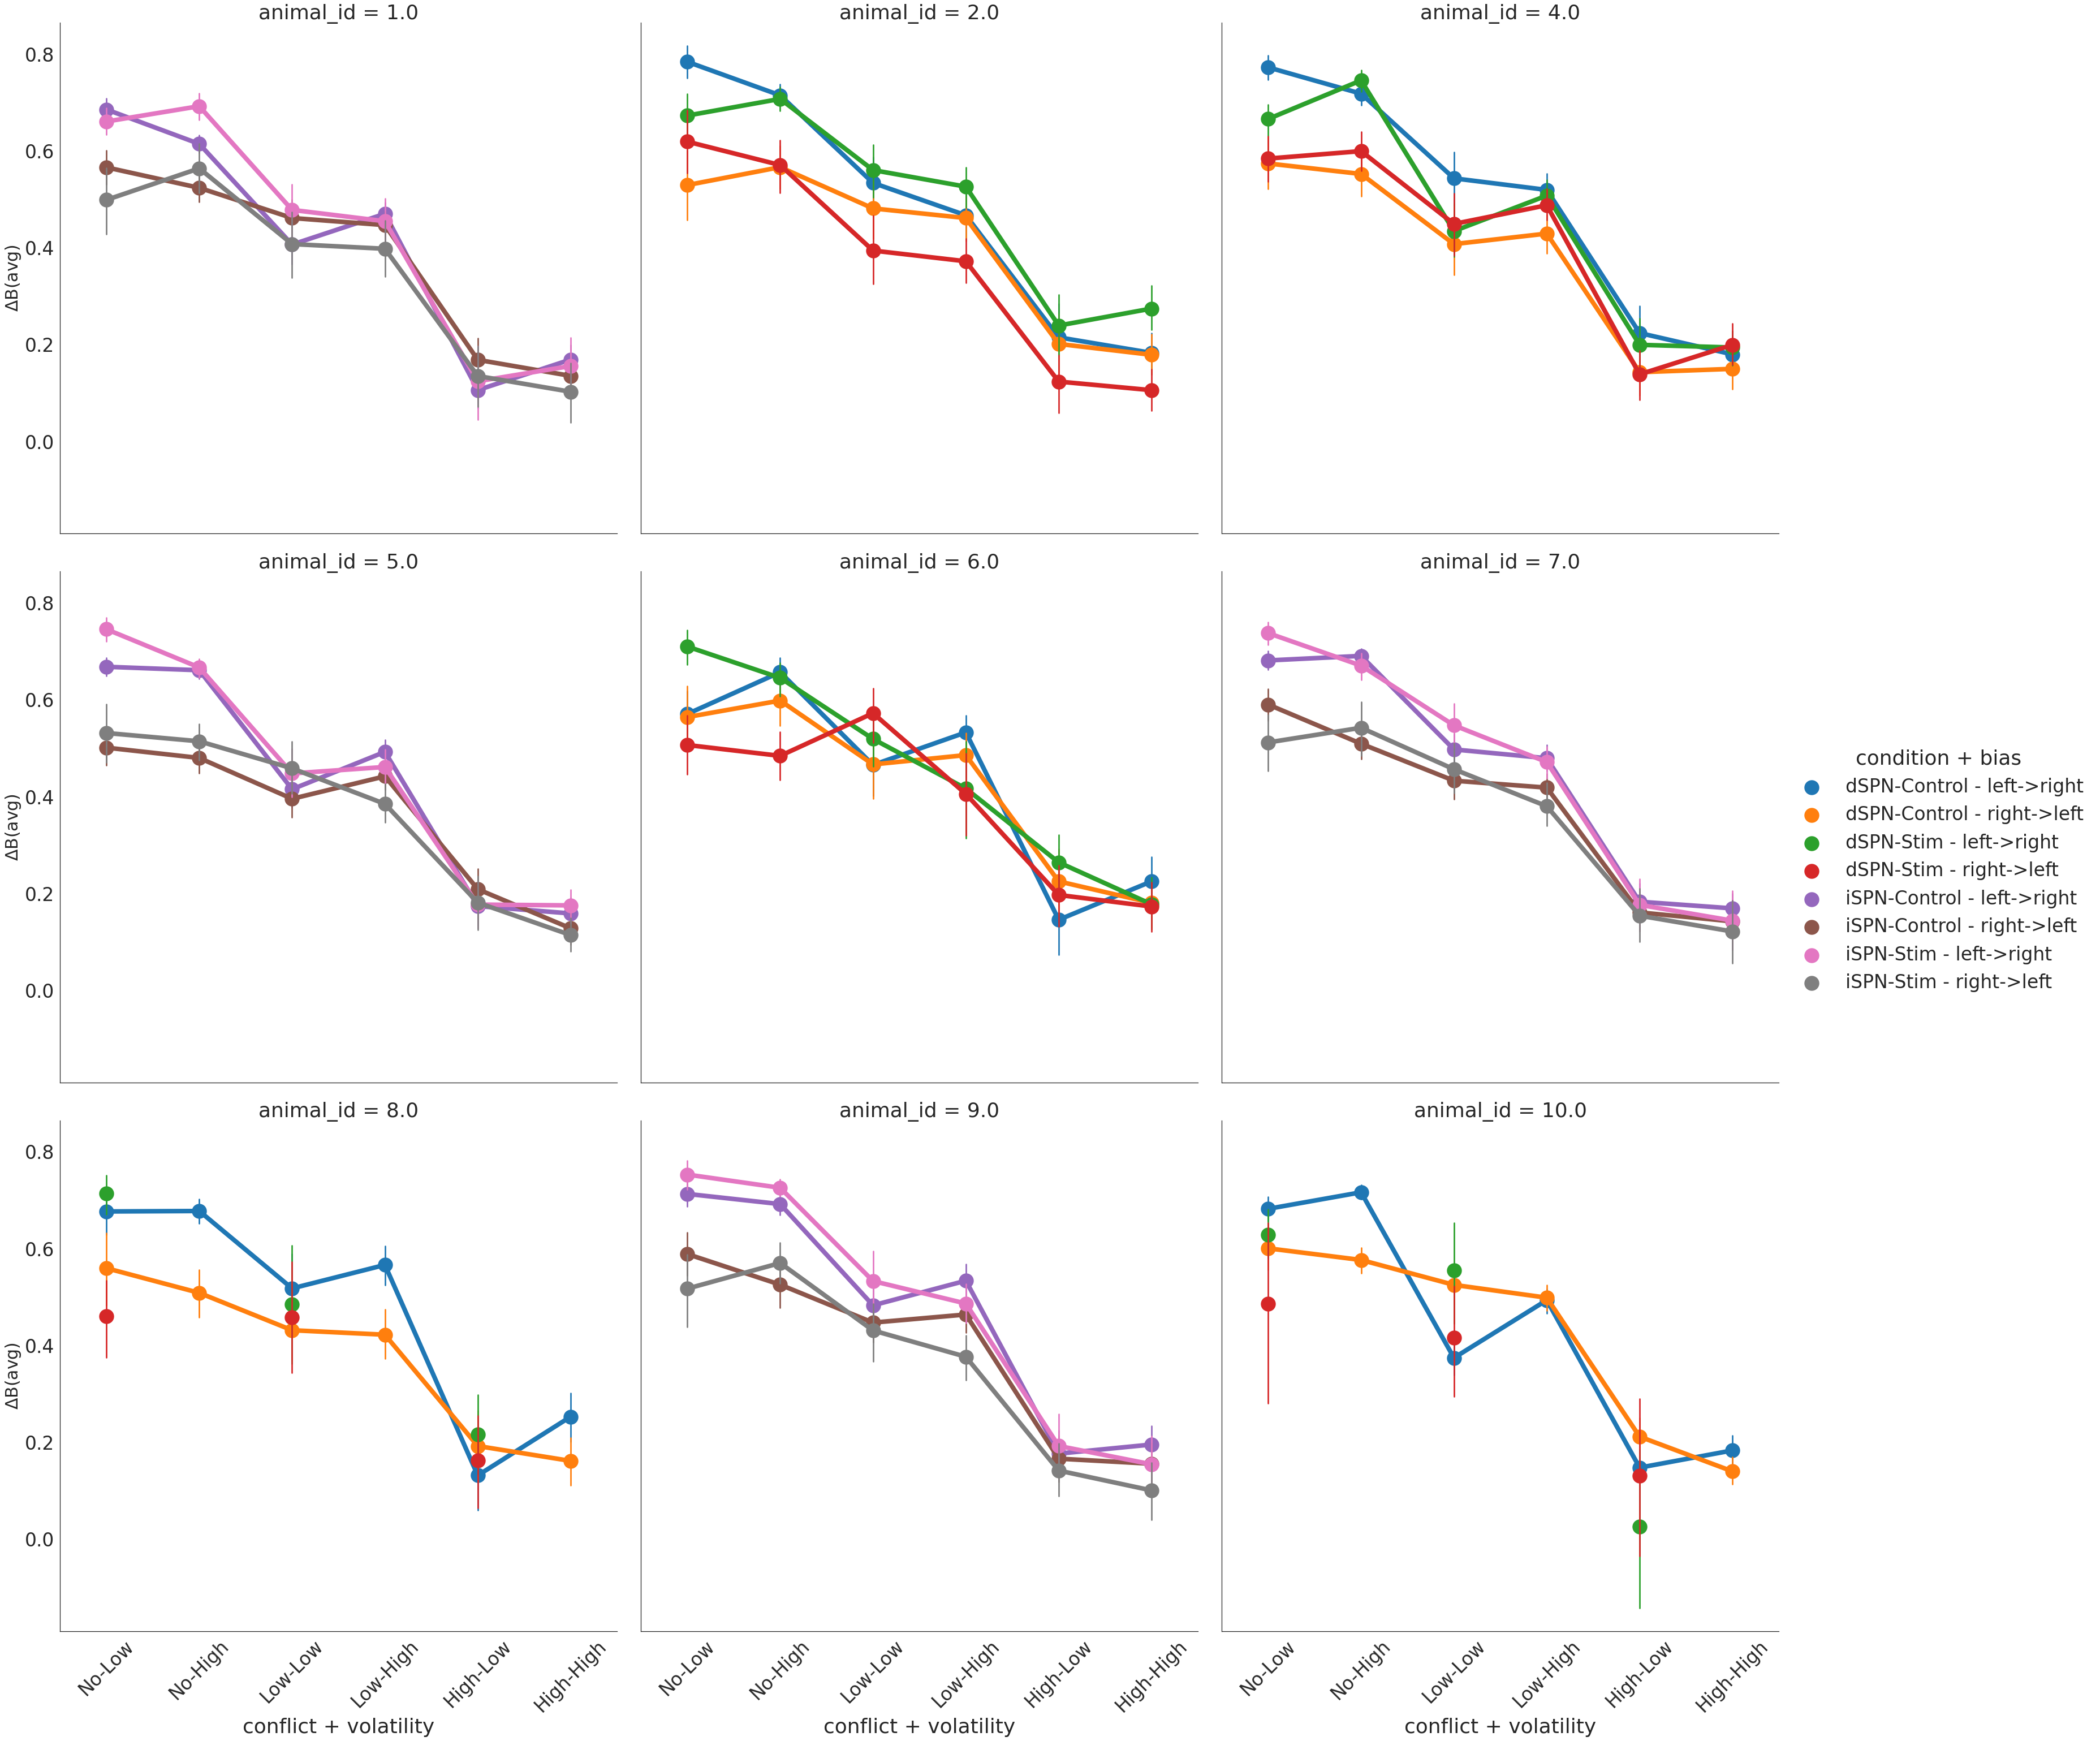

In [292]:
animal_wise_plots(block_change_aligned_df,"avg","ideal_B",[],[],"condition + bias",cond_bias)

condition + bias
['dSPN-Control - left->right', 'dSPN-Control - right->left', 'dSPN-Stim - left->right', 'dSPN-Stim - right->left', 'iSPN-Control - left->right', 'iSPN-Control - right->left', 'iSPN-Stim - left->right', 'iSPN-Stim - right->left']


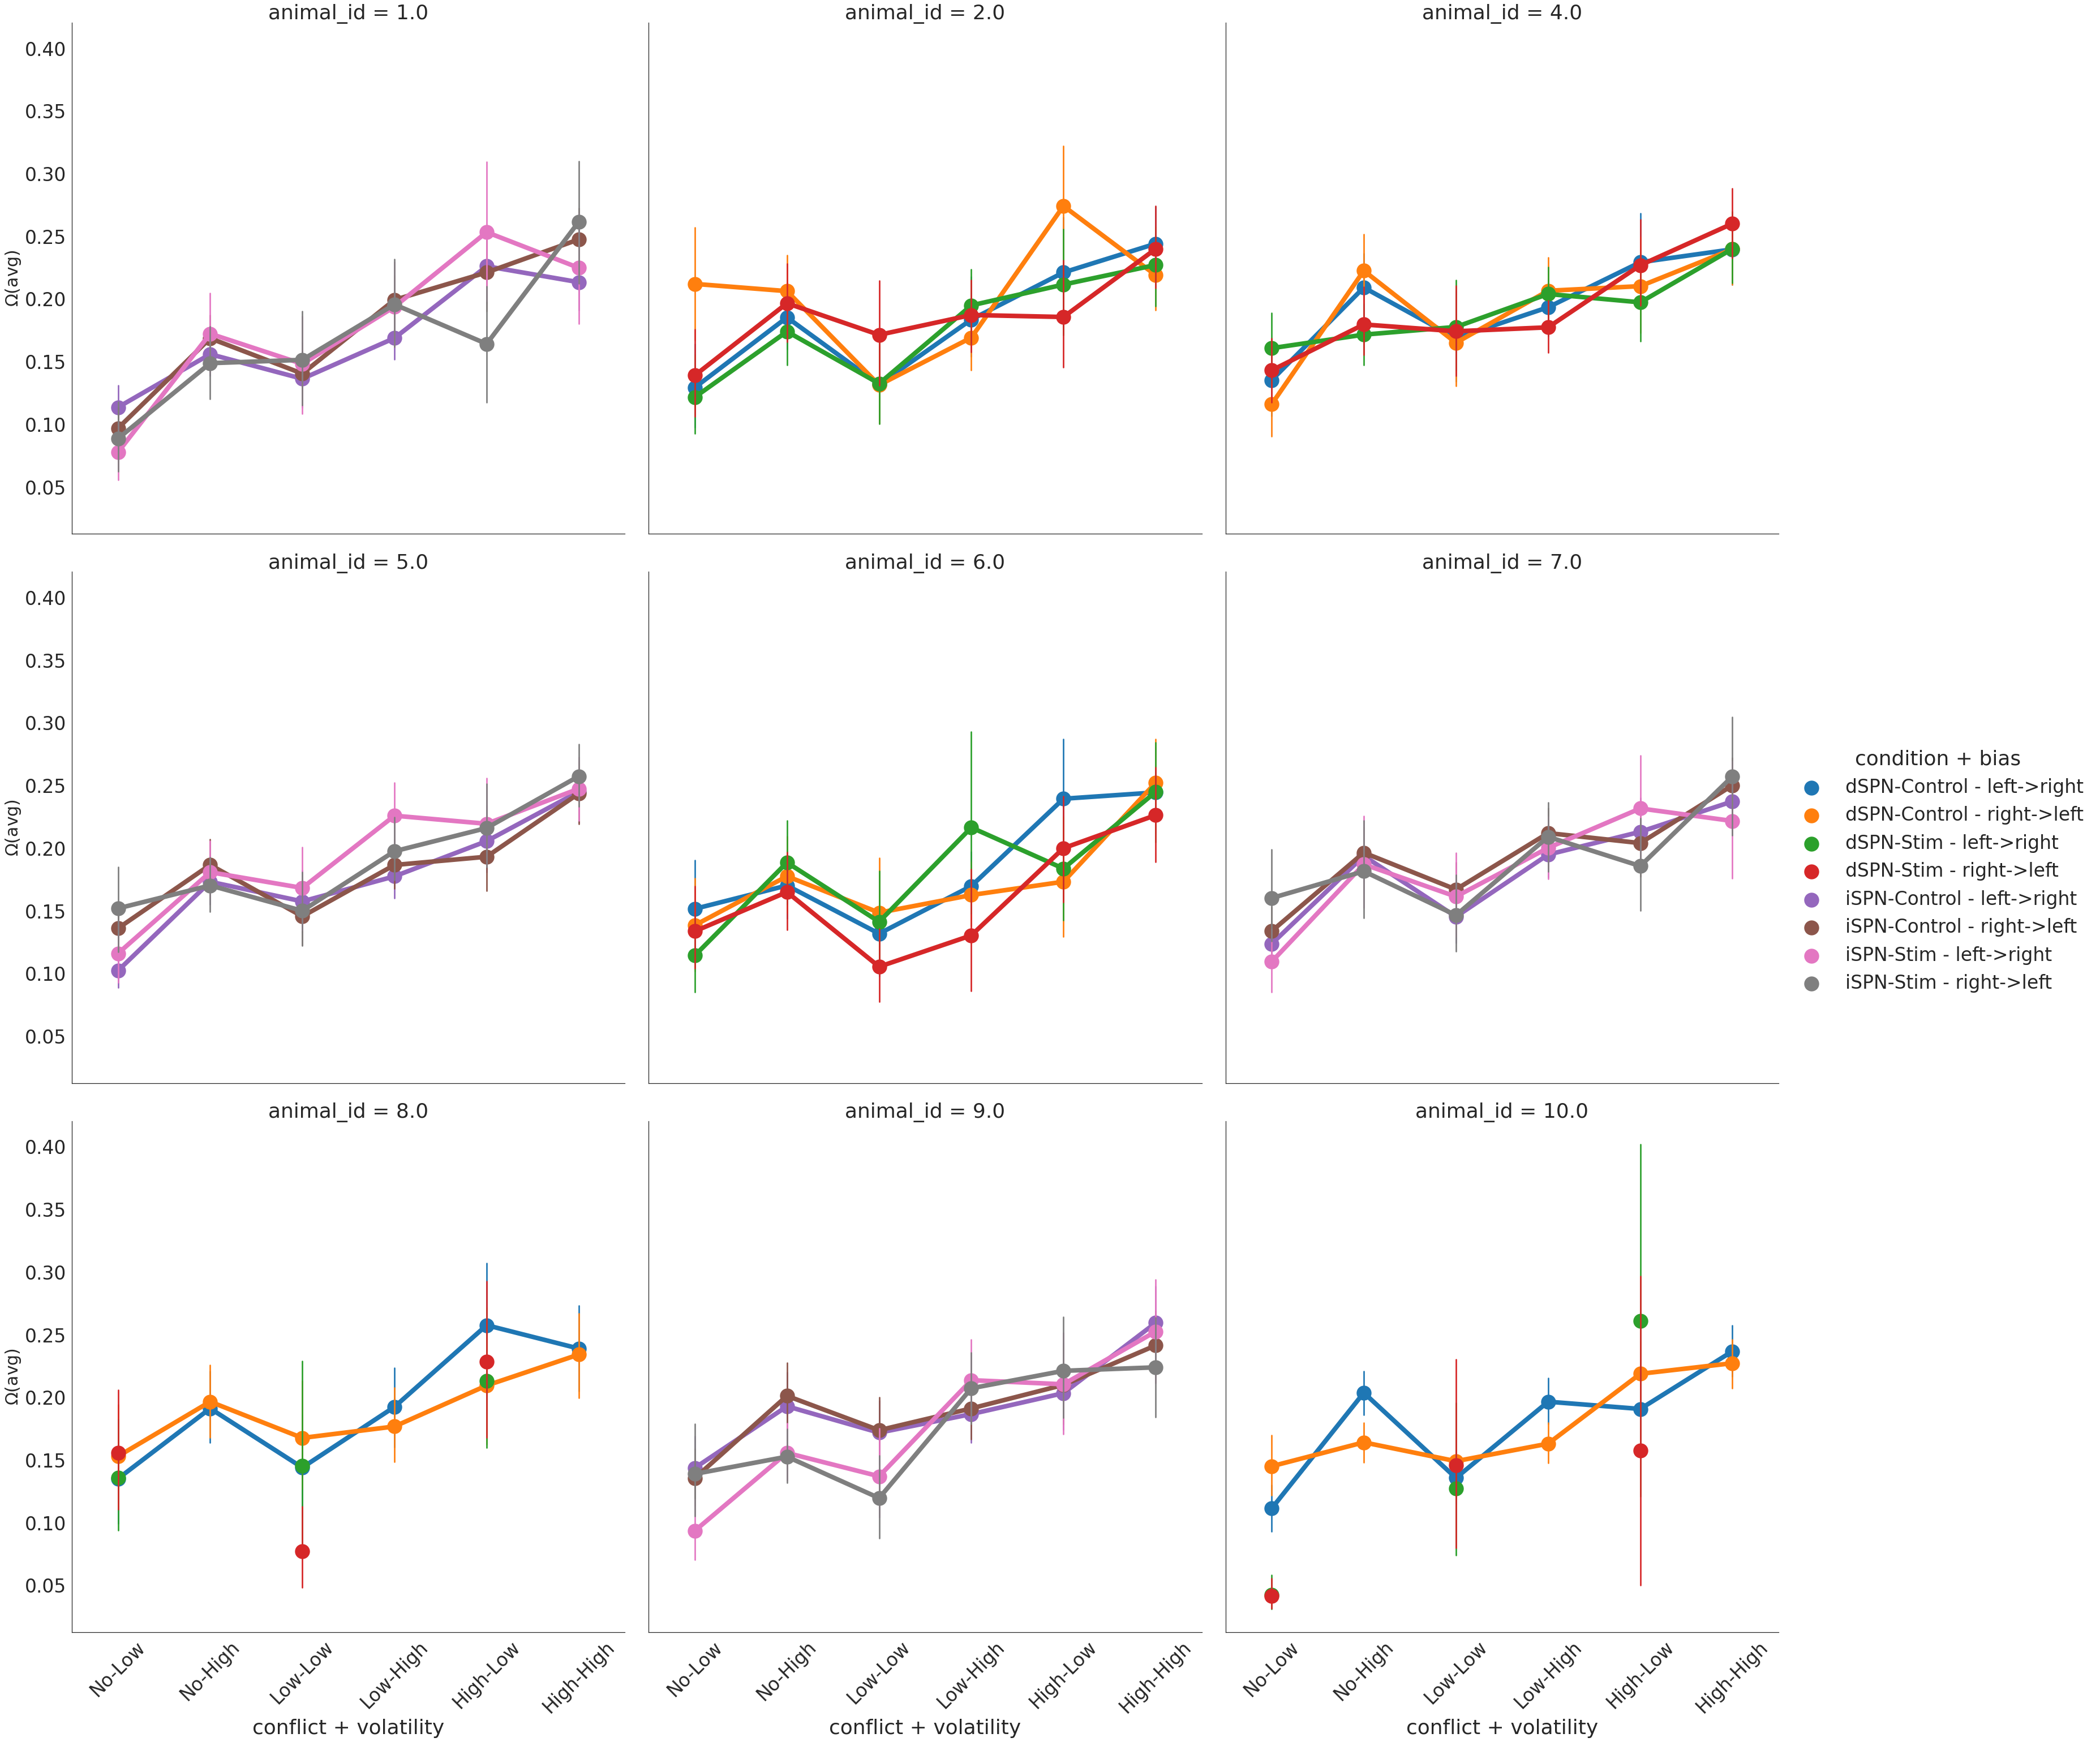

In [293]:
animal_wise_plots(block_change_aligned_df,"avg","cpp",[],[],"condition + bias",cond_bias)

condition + bias
['dSPN-Control - left->right', 'dSPN-Control - right->left', 'dSPN-Stim - left->right', 'dSPN-Stim - right->left', 'iSPN-Control - left->right', 'iSPN-Control - right->left', 'iSPN-Stim - left->right', 'iSPN-Stim - right->left']


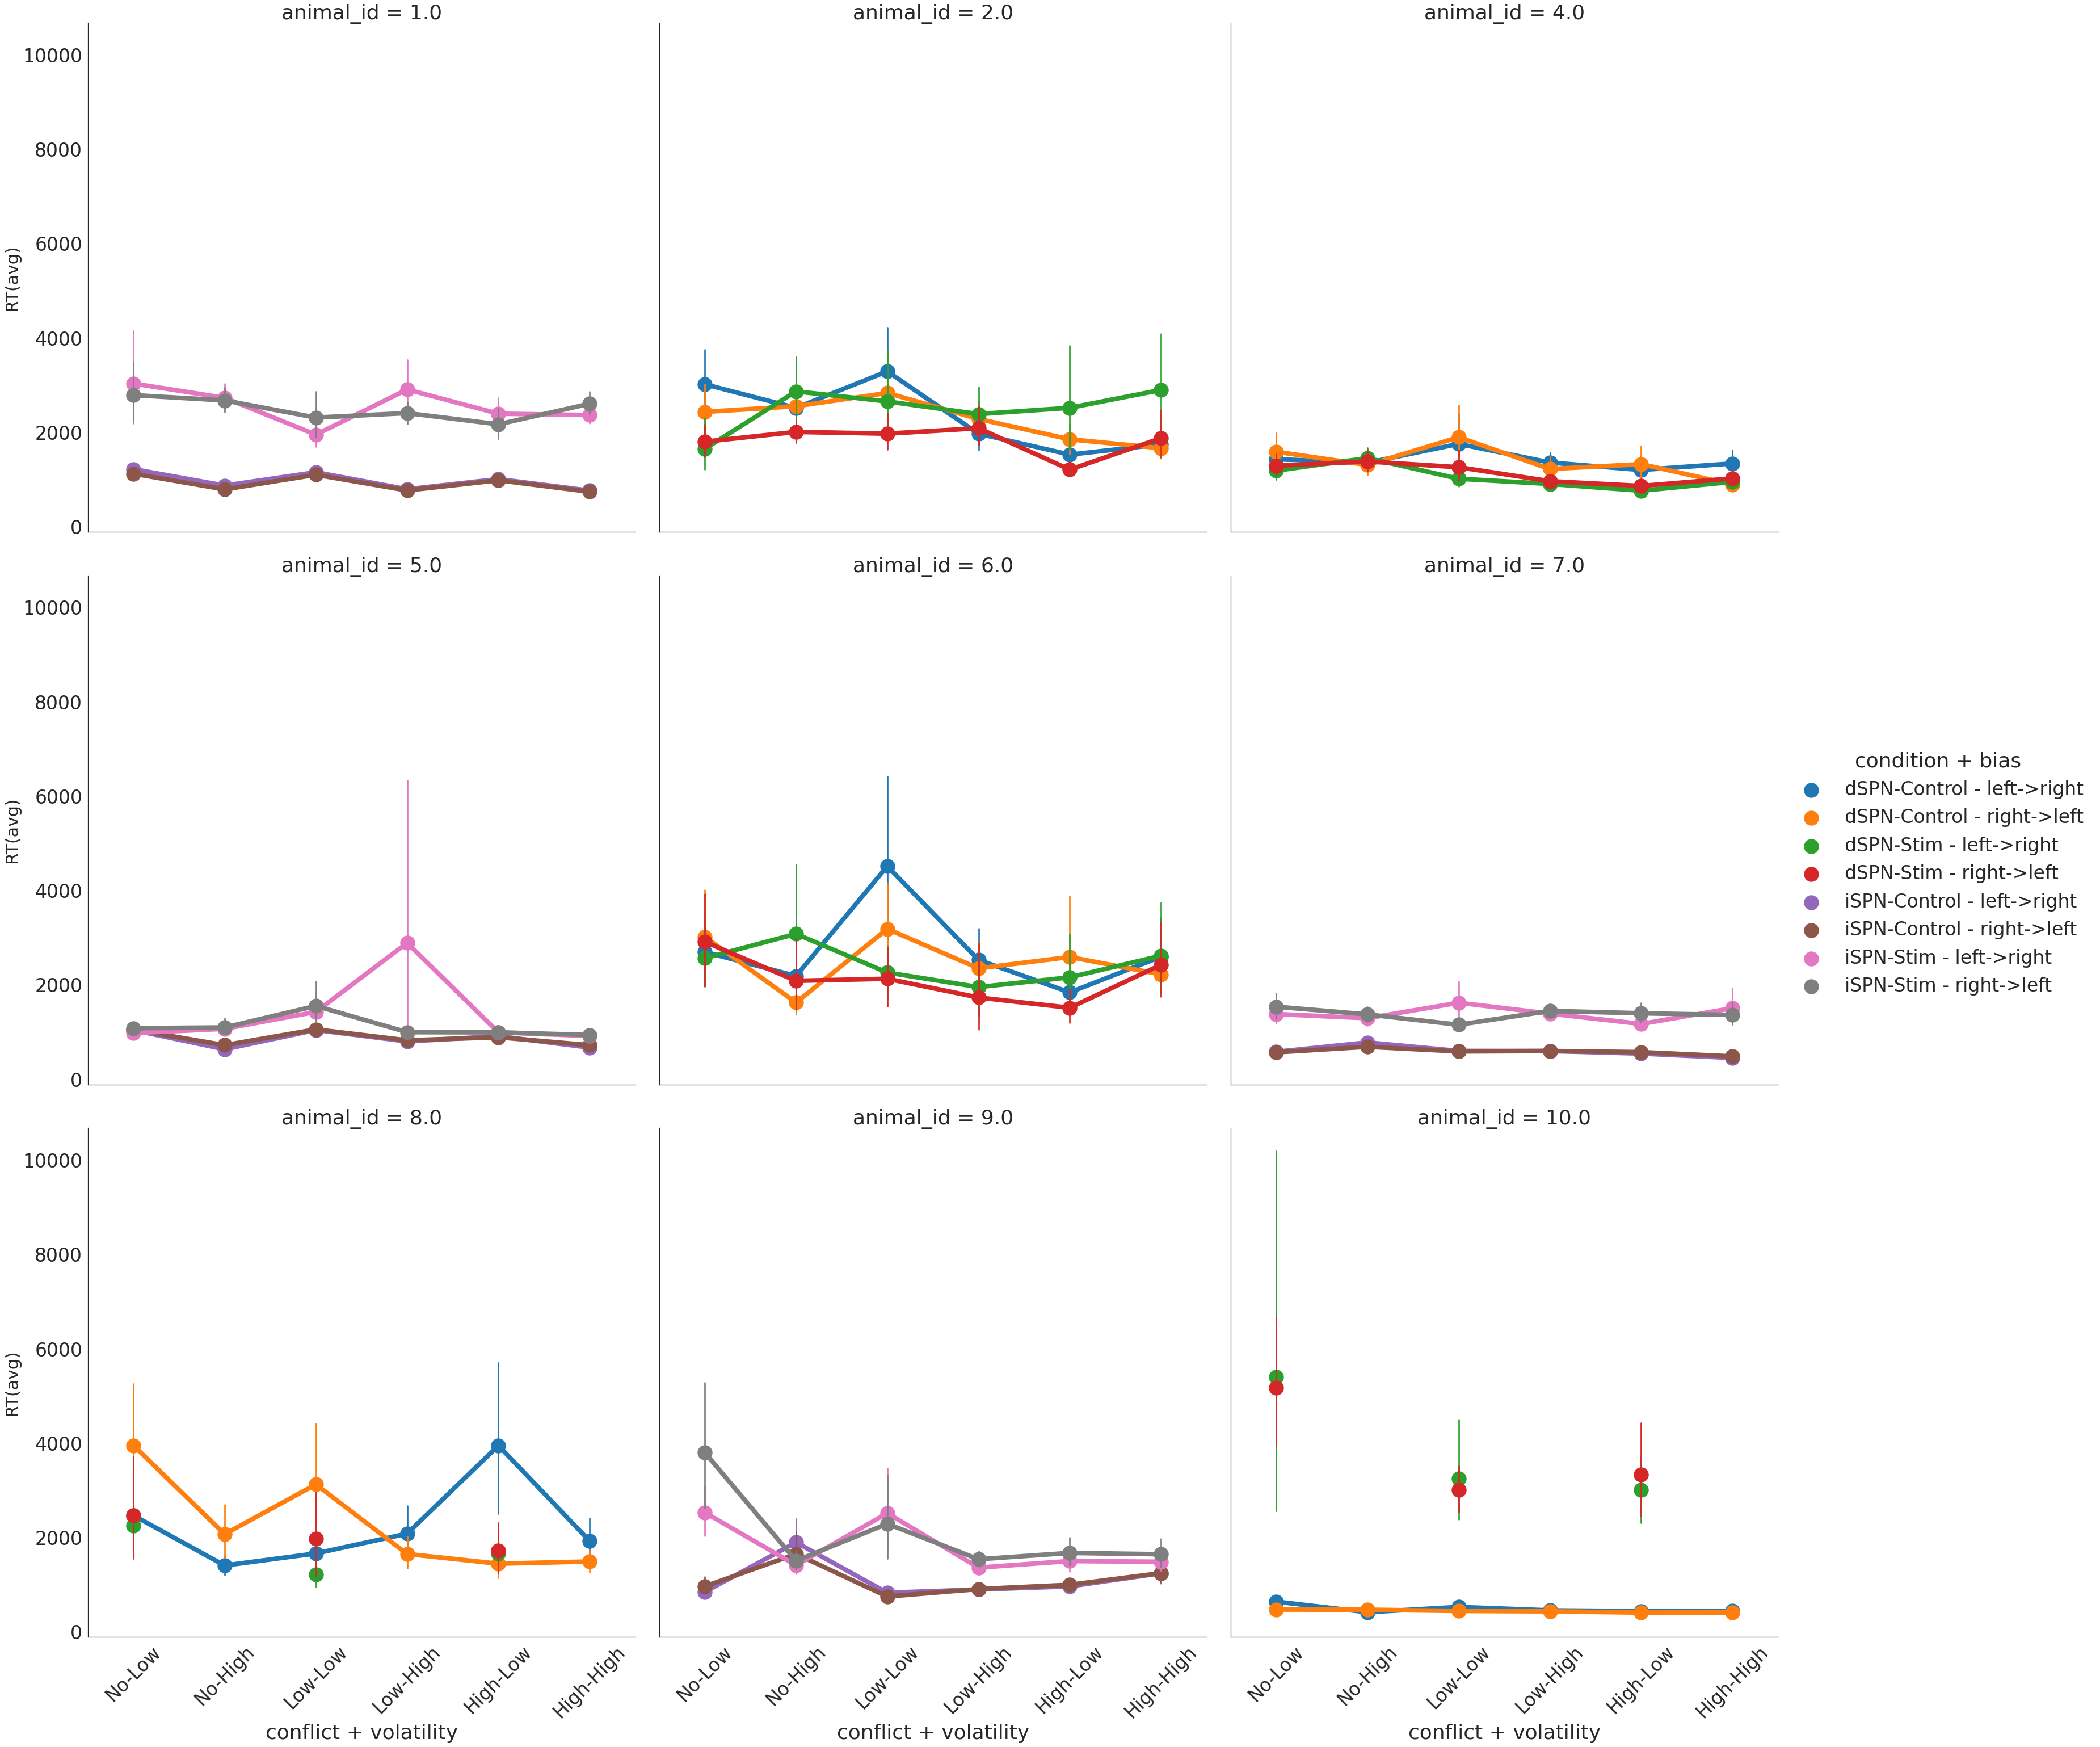

In [294]:
animal_wise_plots(block_change_aligned_df,"avg","rt",[],[],"condition + bias",cond_bias)

3730.2396825396827
2967.9010204081637
1996.6783783783785
2951.310784313726
2543.0918032786885
3316.0975609756097
3560.3063157894744
2360.9410000000003
1070.4375
1077.27523364486
1610.0592920353984
1176.5520618556702
1000.4260869565219
2362.9655913978495
1296.3238095238096
1309.29010989011
1783.0780000000002
1744.6586666666667
3188.975342465754
1878.5857142857144
1415.104794520548
1691.2443298969074
4003.3125000000005
5882.8
2963.888888888889


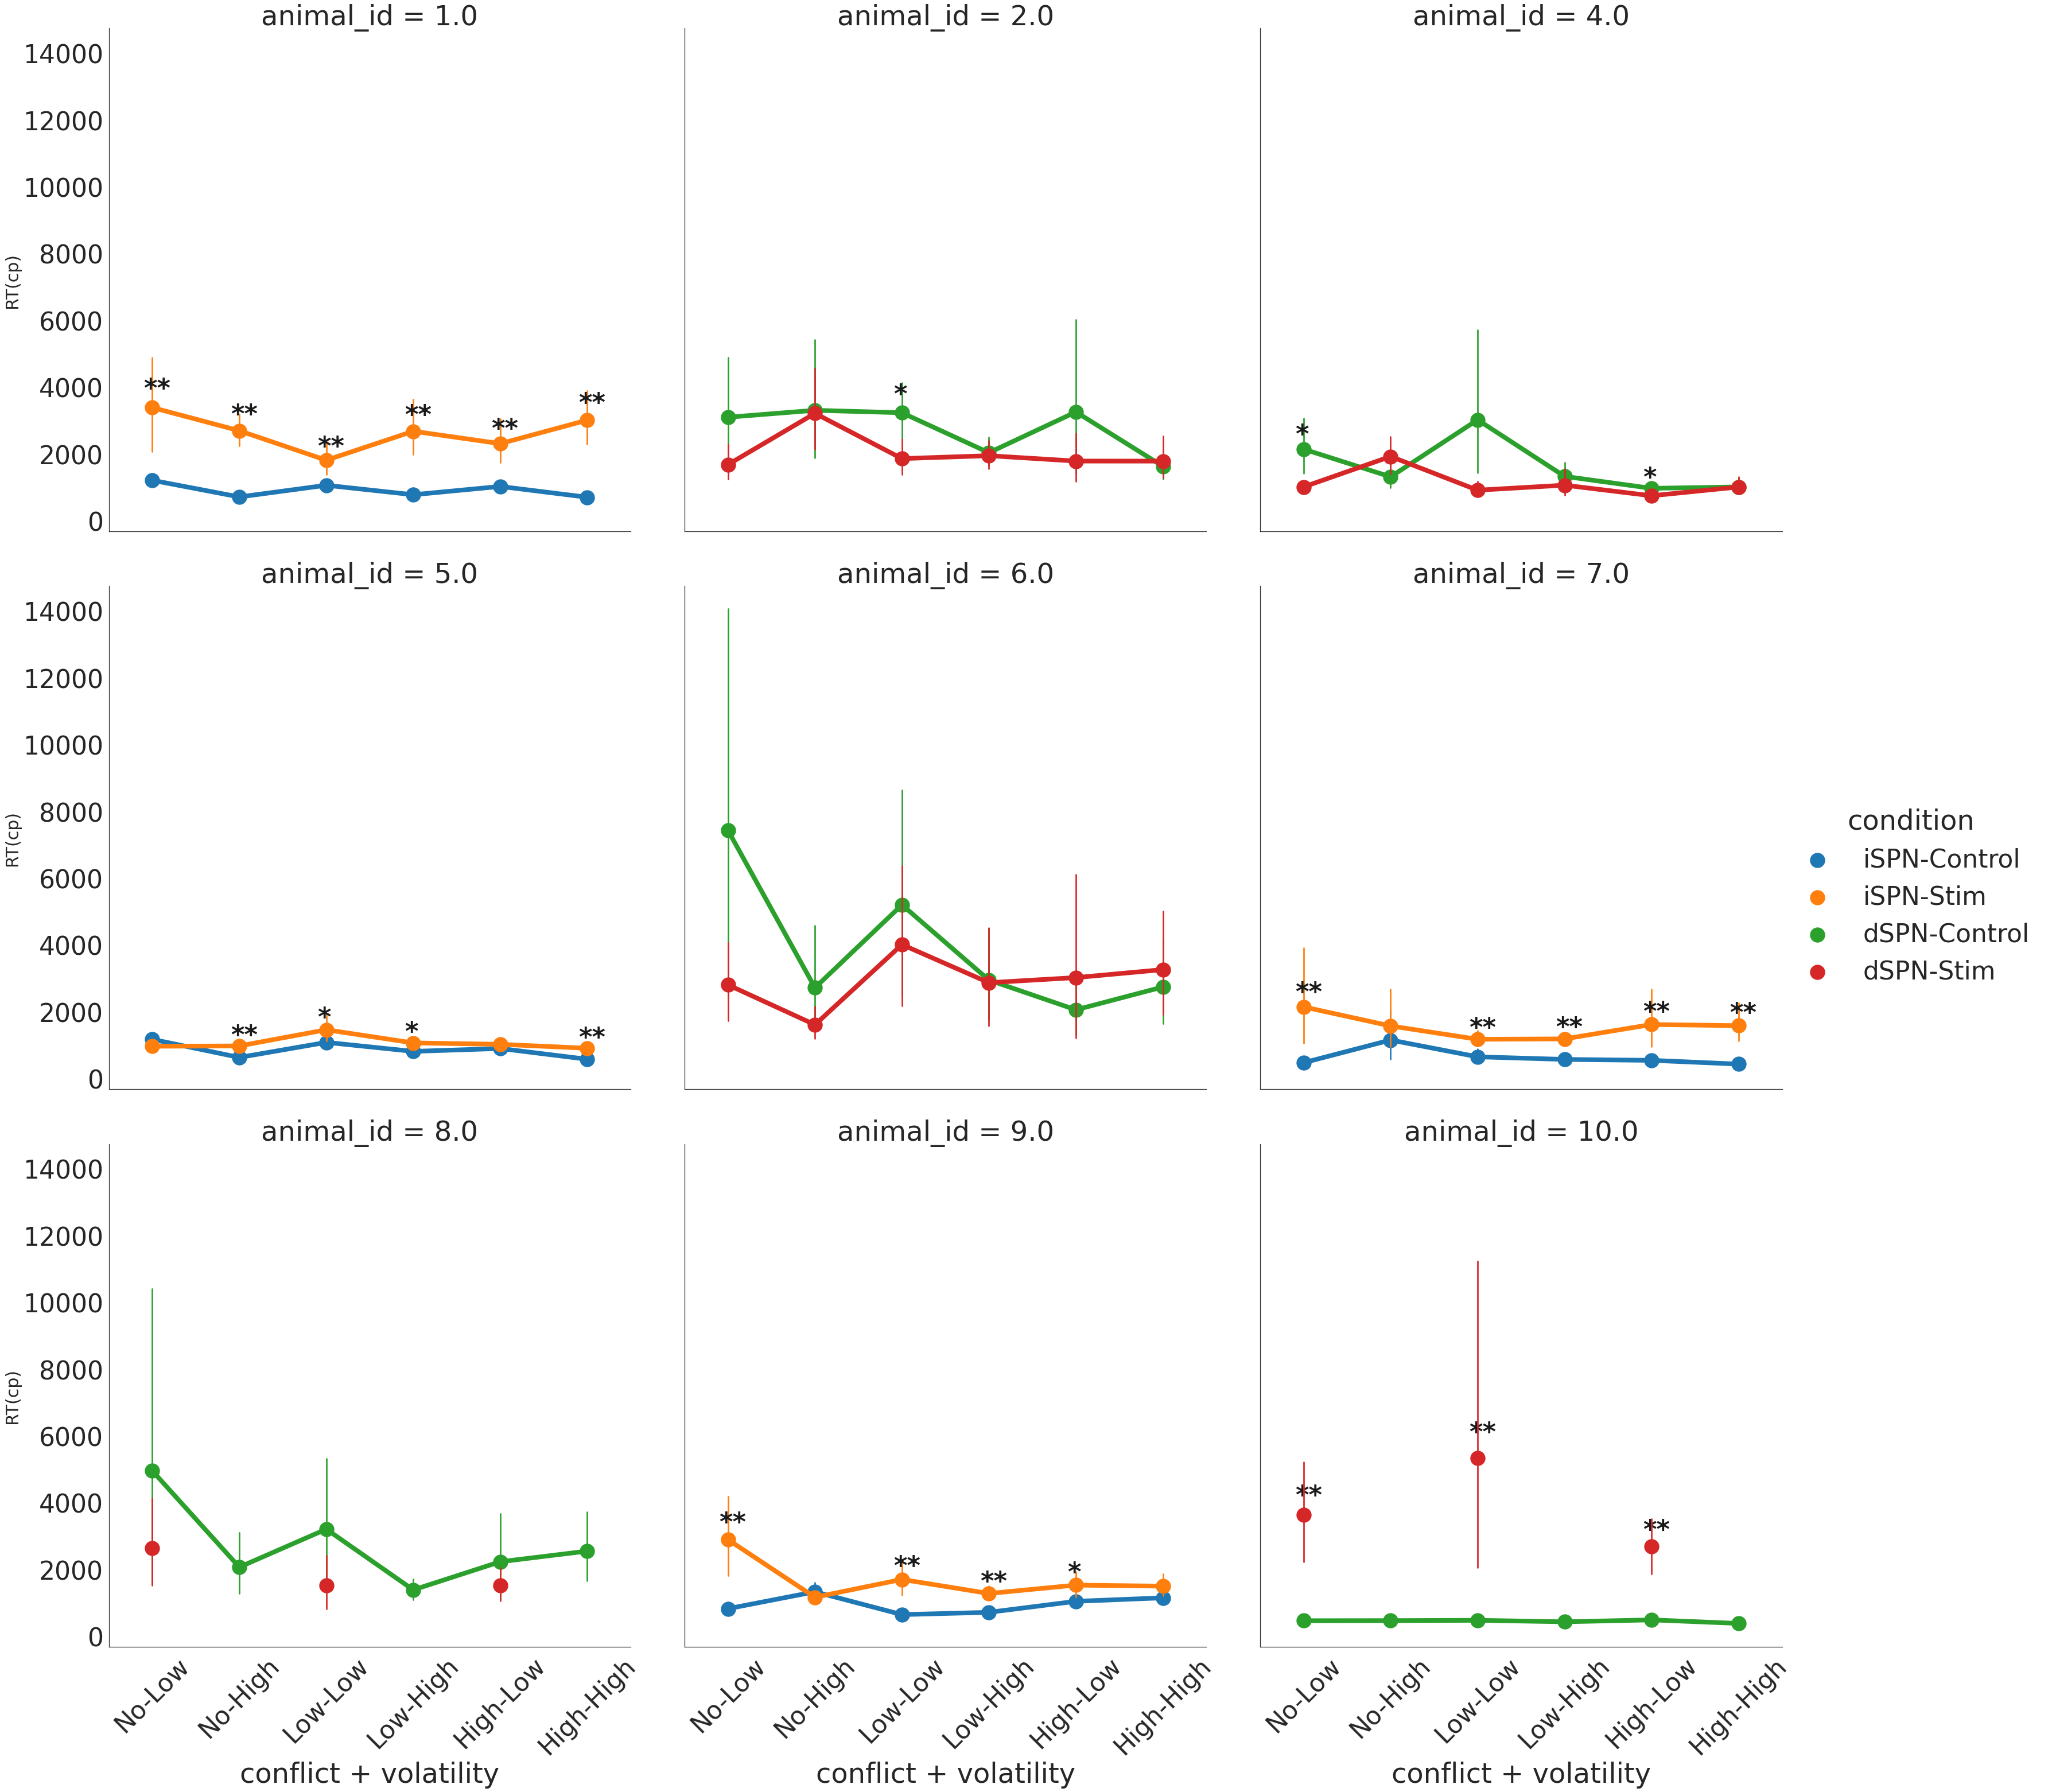

In [168]:
animal_wise_plots(block_change_aligned_df,"cp","rt",ispn_pairs,dspn_pairs)

In [286]:
cond_bias

['dSPN-Control - left->right',
 'dSPN-Control - right->left',
 'dSPN-Stim - left->right',
 'dSPN-Stim - right->left',
 'iSPN-Control - left->right',
 'iSPN-Control - right->left',
 'iSPN-Stim - left->right',
 'iSPN-Stim - right->left']

condition
['iSPN-Control', 'iSPN-Stim', 'dSPN-Control', 'dSPN-Stim']
3201.7017241379313
2973.4537634408603
2346.848861283644
2923.565889212828
2509.765051020408
2734.062087912088
2997.737837837838
2617.3133072407045
2007.0692436974791
1420.4971273291926
1391.4809078771696
1191.4834586466168
1641.3236772486773
1020.4388248847927
4269.790929705216
1605.7
1466.6496981891348
1527.0184285714288
1561.2160613397903
1412.504210526316
1579.5634050880628
3459.1972689075633
2642.44007936508
1596.3306990881458
1749.2869565217393
1720.9674603174606
5800.4571428571435
3434.8451127819553
3488.983928571429


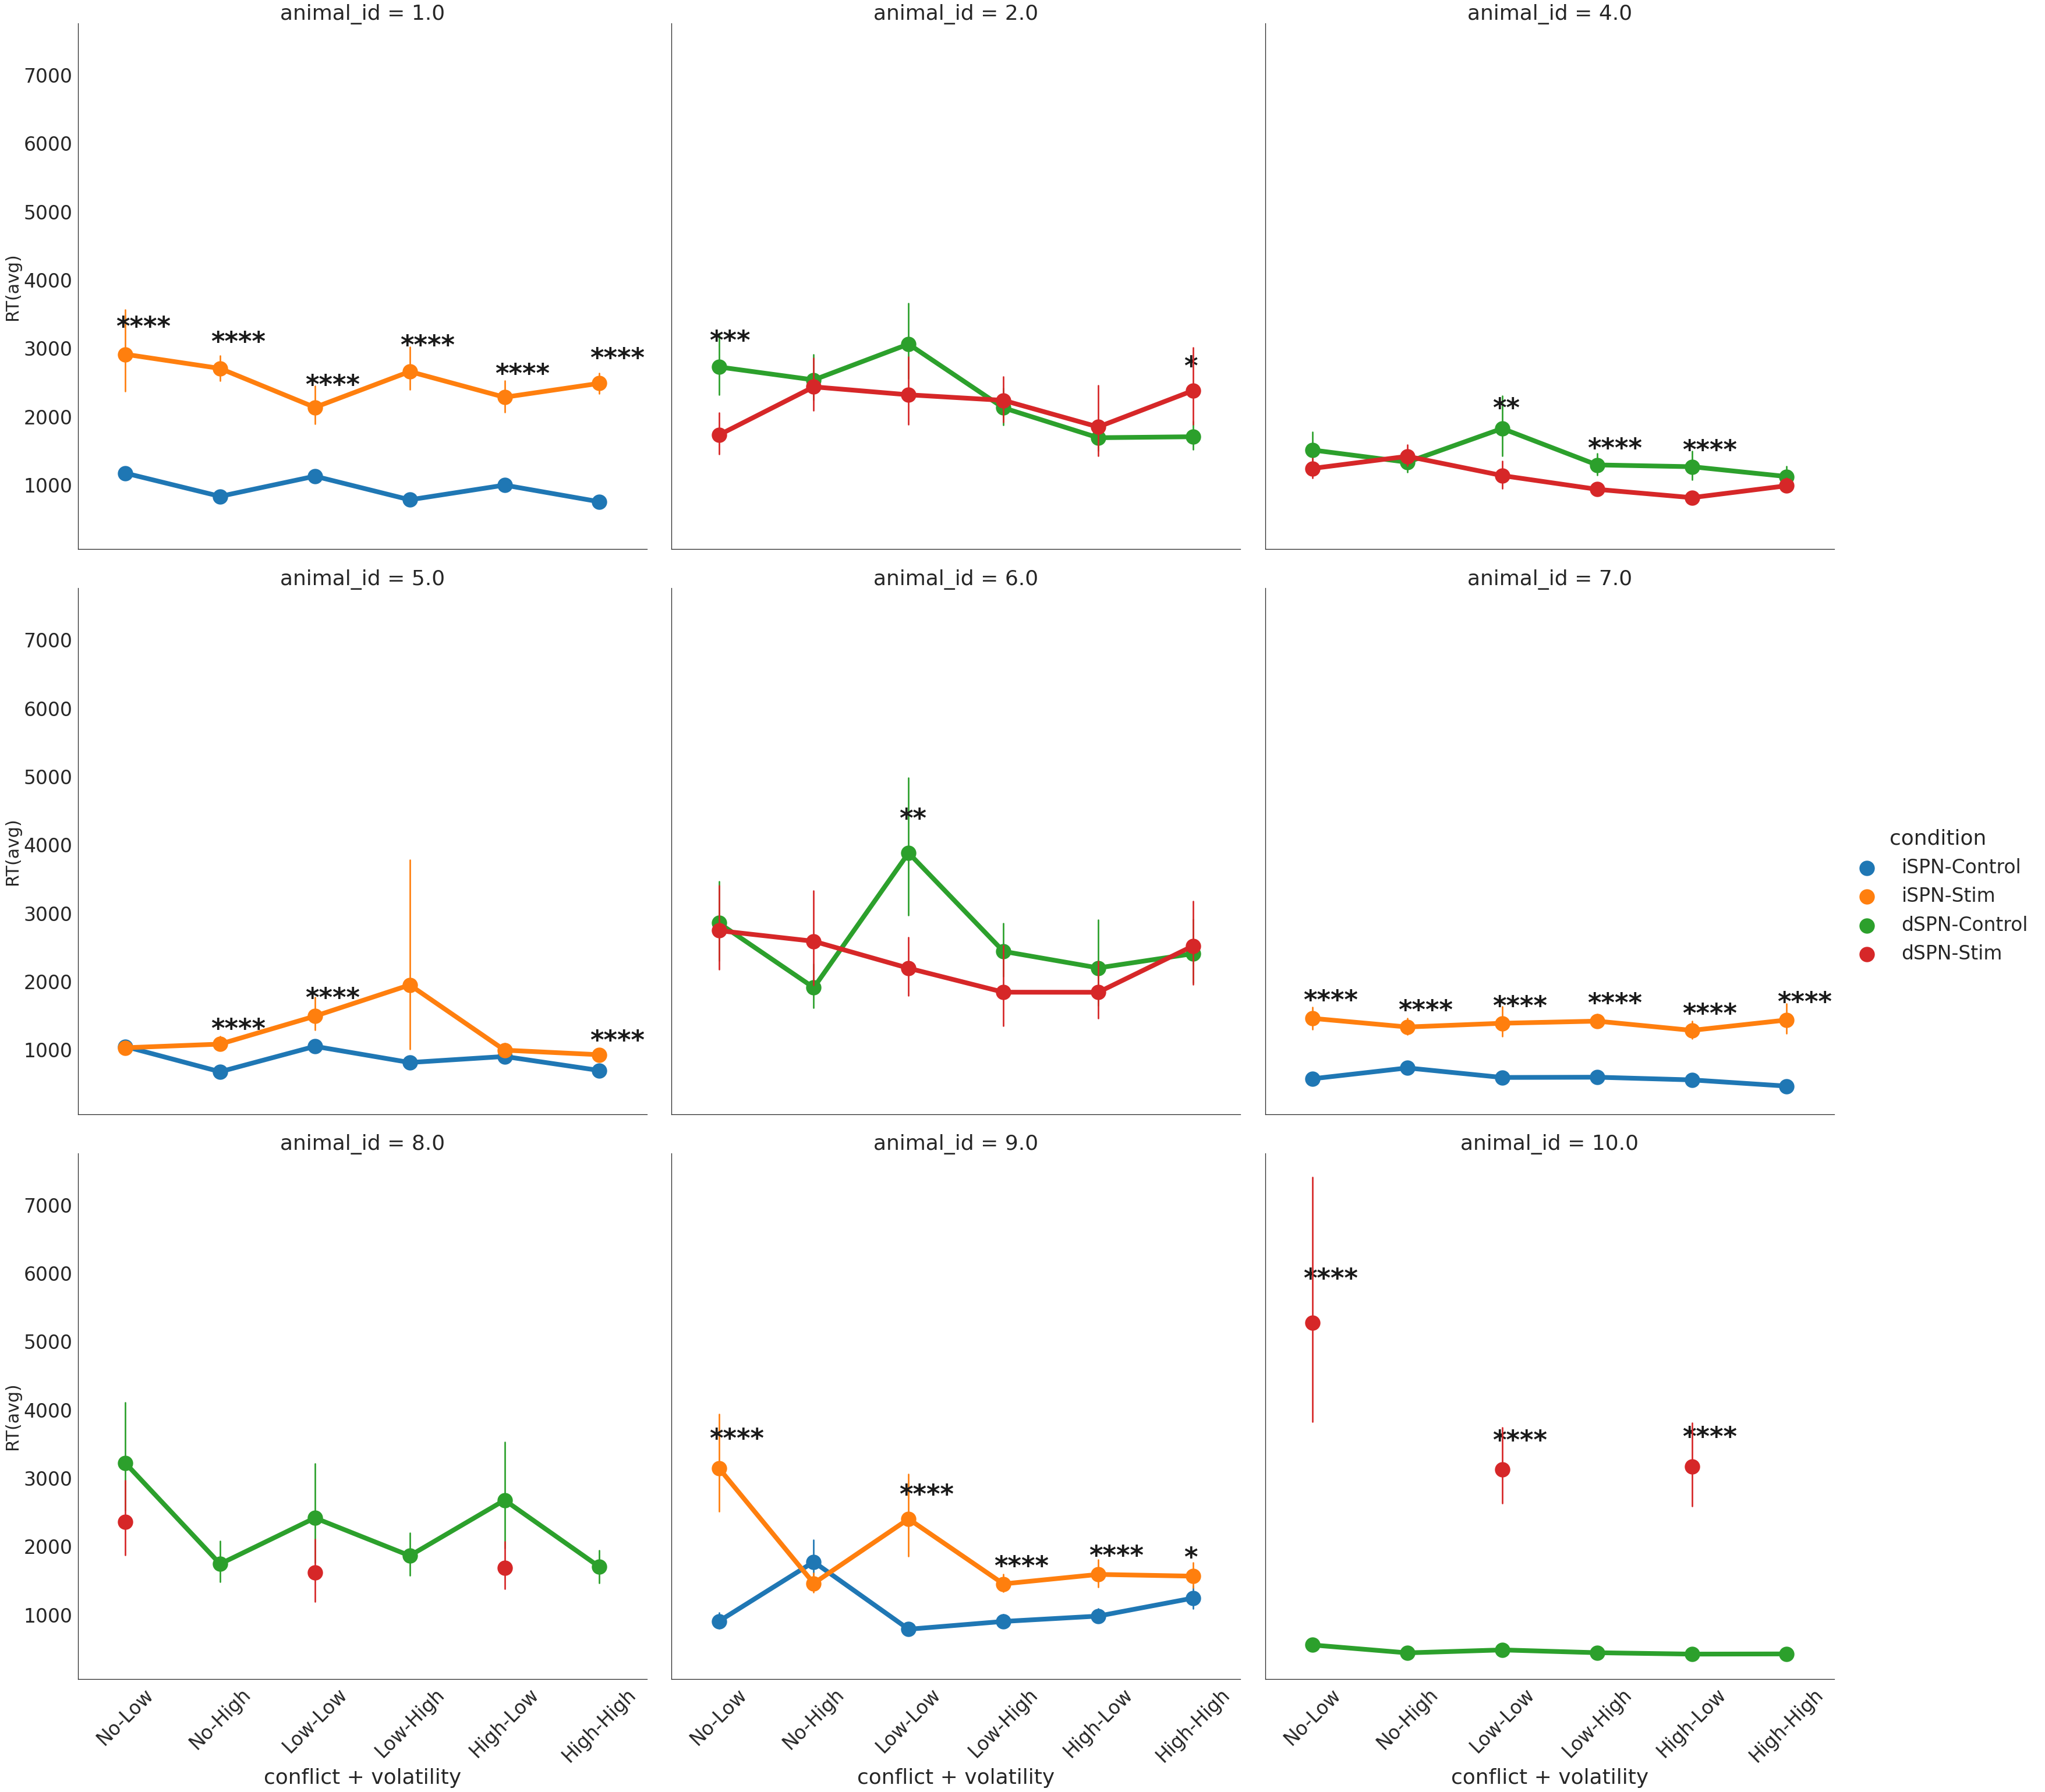

In [297]:
animal_wise_plots(block_change_aligned_df,"avg","rt",ispn_pairs,dspn_pairs,"condition",hue_order)

In [215]:
# average corrected
block_change_aligned_df_avg_corrected = pd.DataFrame()
for grp in block_change_aligned_df.groupby(["animal_id","conflict","volatility","condition","session","block_num"]):
    avg_b = grp[1].loc[grp[1]["trials_from_change_point"]>2]["ideal_B"].mean()
    avg_cpp = grp[1].loc[grp[1]["trials_from_change_point"]>2]["cpp"].mean()
    avg_rt = grp[1].loc[grp[1]["trials_from_change_point"]>2]["rt"].mean()
    avg_cp= grp[1].loc[grp[1]["trials_from_change_point"]==0]["rt"].mean()
    
    grp[1]["ideal_B"] = (grp[1]["ideal_B"]-avg_b)*100
    grp[1]["cpp"] = (grp[1]["cpp"]-avg_cpp)*100
    grp[1]["rt/rt(cp)"] = grp[1]["rt"].values/avg_cp 
    grp[1]["rt/rt(avg)"] = grp[1]["rt"].values/avg_rt 
    #grp[1]["rt"] = (grp[1]["rt"]-avg_rt)*100
    
    block_change_aligned_df_avg_corrected = block_change_aligned_df_avg_corrected.append(grp[1])
block_change_aligned_df_avg_corrected = block_change_aligned_df_avg_corrected.reset_index()    
block_change_aligned_df_avg_corrected.to_csv(data_target_dir2+"block_change_aligned_df_avg_corrected.csv")

In [213]:
block_change_aligned_df_avg_corrected.columns

Index(['index', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'r_t0', 'r_t1',
       'cp', 'epoch_number', 'reward_p_t0', 'session', 'conflict',
       'volatility', 'condition', 'p_id_solution', 'action_history',
       'chosen_action', 'trial_num', 'animal_id', 'optimal', 'rt', 'block_num',
       'cpp', 'ideal_B', 'b_t0', 'b_t1', 'MC', 'learning_rate',
       'H(hazard_rate)', 'sigma_estimated', 'u_val', 'n_val', 'block_change',
       'trials_from_change_point', 'block_change_type', 'block_num_change',
       'nuclei', 'experiment_type', 'experiment_type1',
       'conflict + volatility', 'response', 'rt/rt(cp)]'],
      dtype='object')

FileNotFoundError: [Errno 2] No such file or directory: './Figures/Y_maze/aligned_rt/rt(avg)_avg_corrected_all.png'

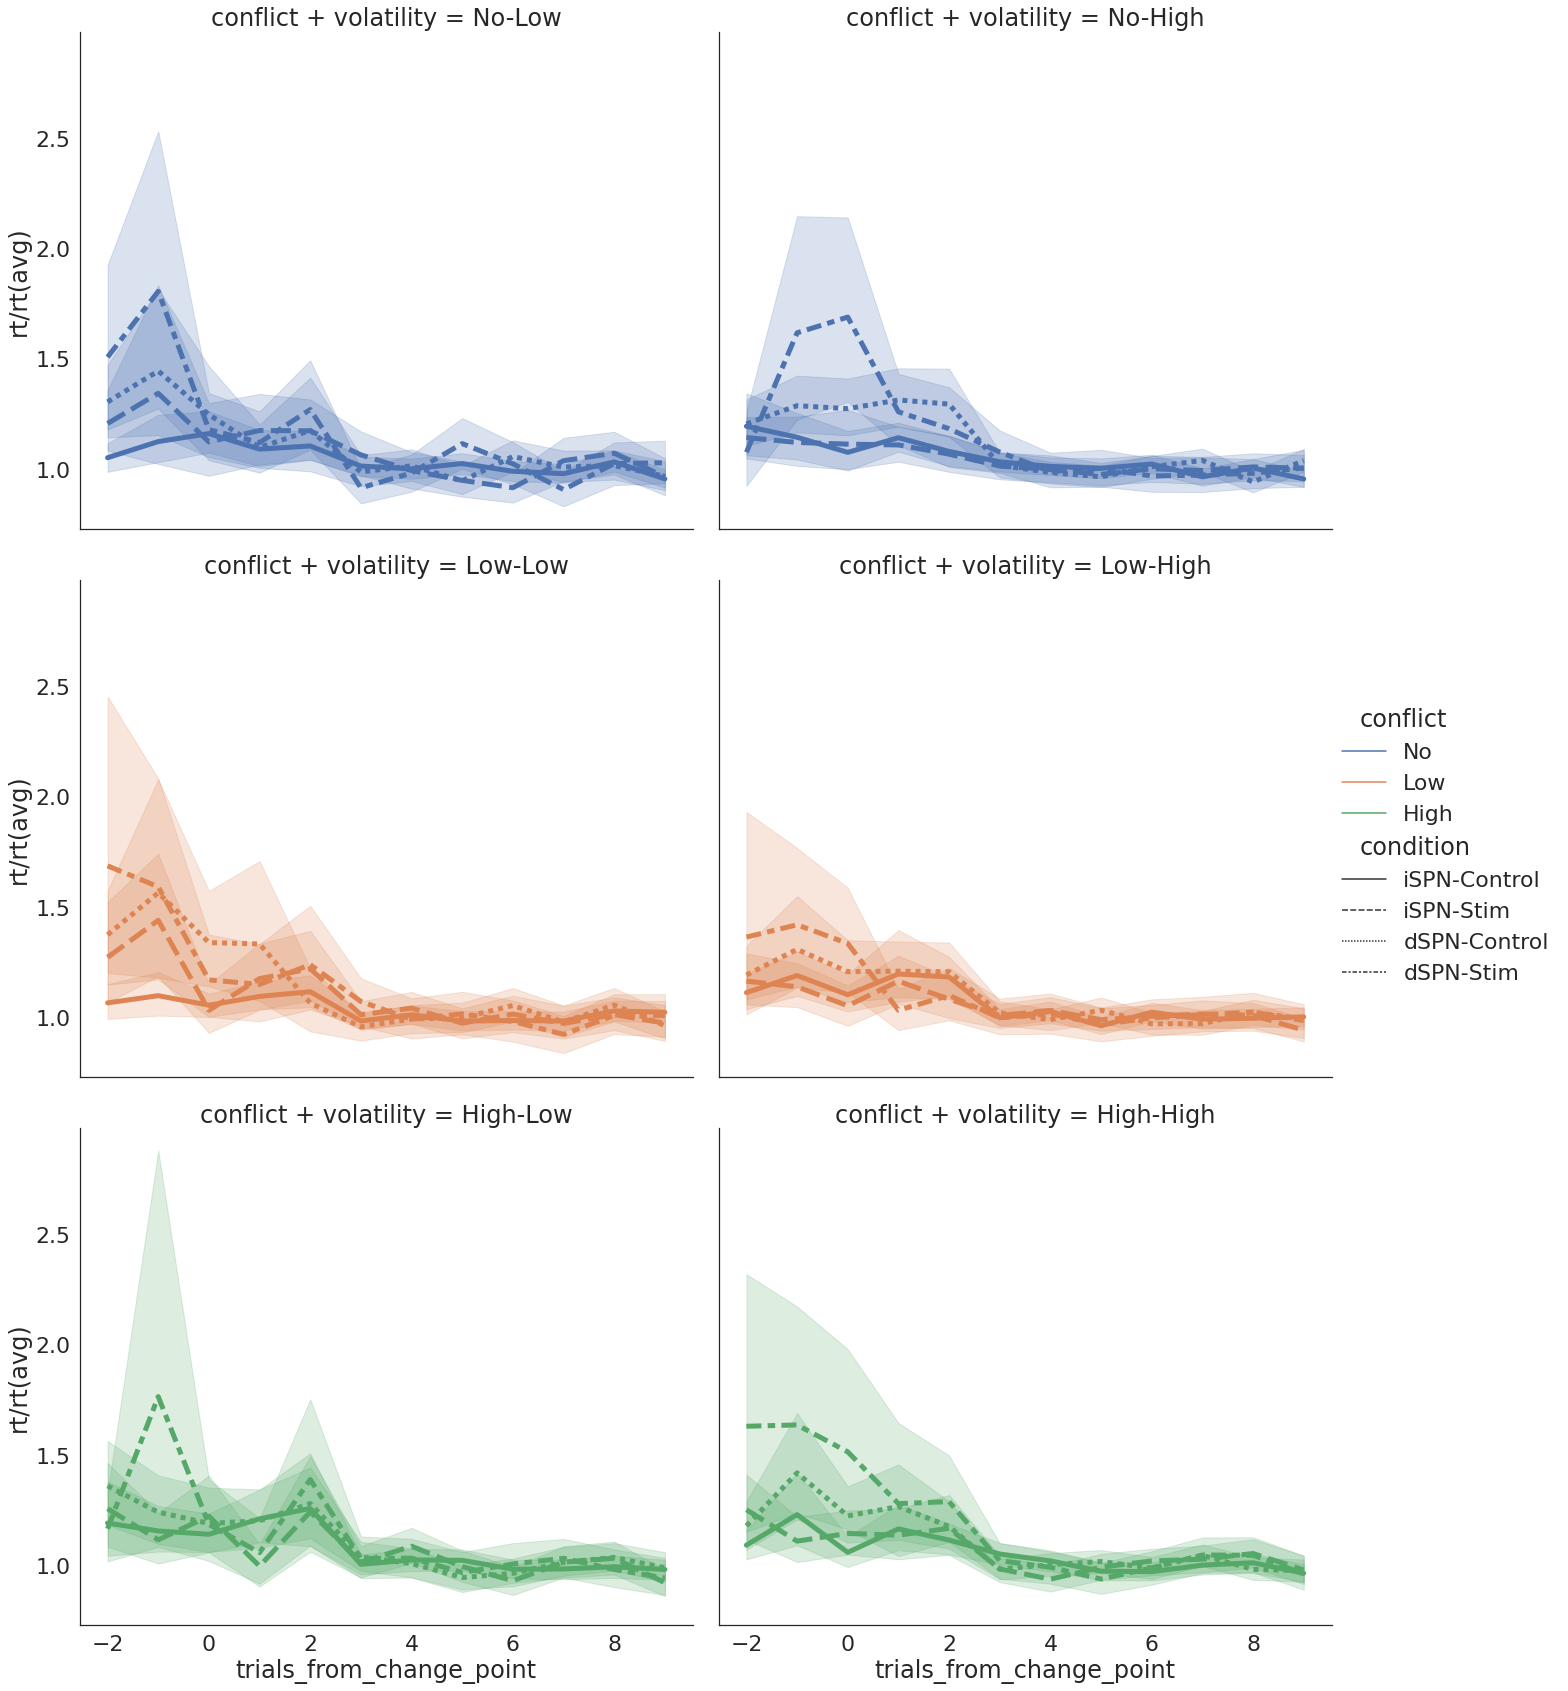

In [216]:
# for grp in block_change_aligned_df.groupby("animal_id"):

# for pars in ["ideal_B","cpp","response","rt/rt(cp)"]:
for pars in ["rt/rt(avg)"]:
    sns.set(font_scale=2)
    plt.rcParams["figure.facecolor"] = "w"
    sns.set_style(style='white')

    g1 = sns.relplot(x="trials_from_change_point",y=pars,hue="conflict",col="conflict + volatility",style="condition",data=block_change_aligned_df_avg_corrected,kind='line',height=8,aspect=1.2,lw=5.0,hue_order=["No","Low","High"],style_order=["iSPN-Control","iSPN-Stim","dSPN-Control","dSPN-Stim"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2)
    for ax in g1.axes:
        vol = ax.get_title().split(' = ')[1]
        df = grp[1].loc[grp[1]["volatility"]==vol]
        if pars == "ideal_B":
            ax.set_ylabel(r'$\Delta$'+"B"+"%(avg-cp)",fontsize=20)
        elif pars == "cpp":
            ax.set_ylabel(r'$\Omega$'+"%(avg-cp)",fontsize=20)
    #     for x in ax.get_xticklabels():
    #         x.set_fontsize(15)
    #     for x in ax.get_yticklabels():
    #         x.set_fontsize(15)
    g1.fig.savefig(fig_target_dir+"aligned_"+pars+"_avg_corrected_all.png")

In [246]:
rt_zscored = pd.DataFrame()
for grp in block_change_aligned_df.groupby("animal_id"):
    # zscore RTs per animal over all conditions
#     avg_rt = grp[1]["rt"].mean()
#     sd_rt = grp[1]["rt"].std()
    
    grp[1]["RT(zscored)"] = sp_st.zscore(grp[1]["rt"])
    
    rt_zscored = rt_zscored.append(grp[1])
rt_zscored = rt_zscored.reset_index()    
rt_zscored.to_csv(data_target_dir2+"zscored_RTs.csv")

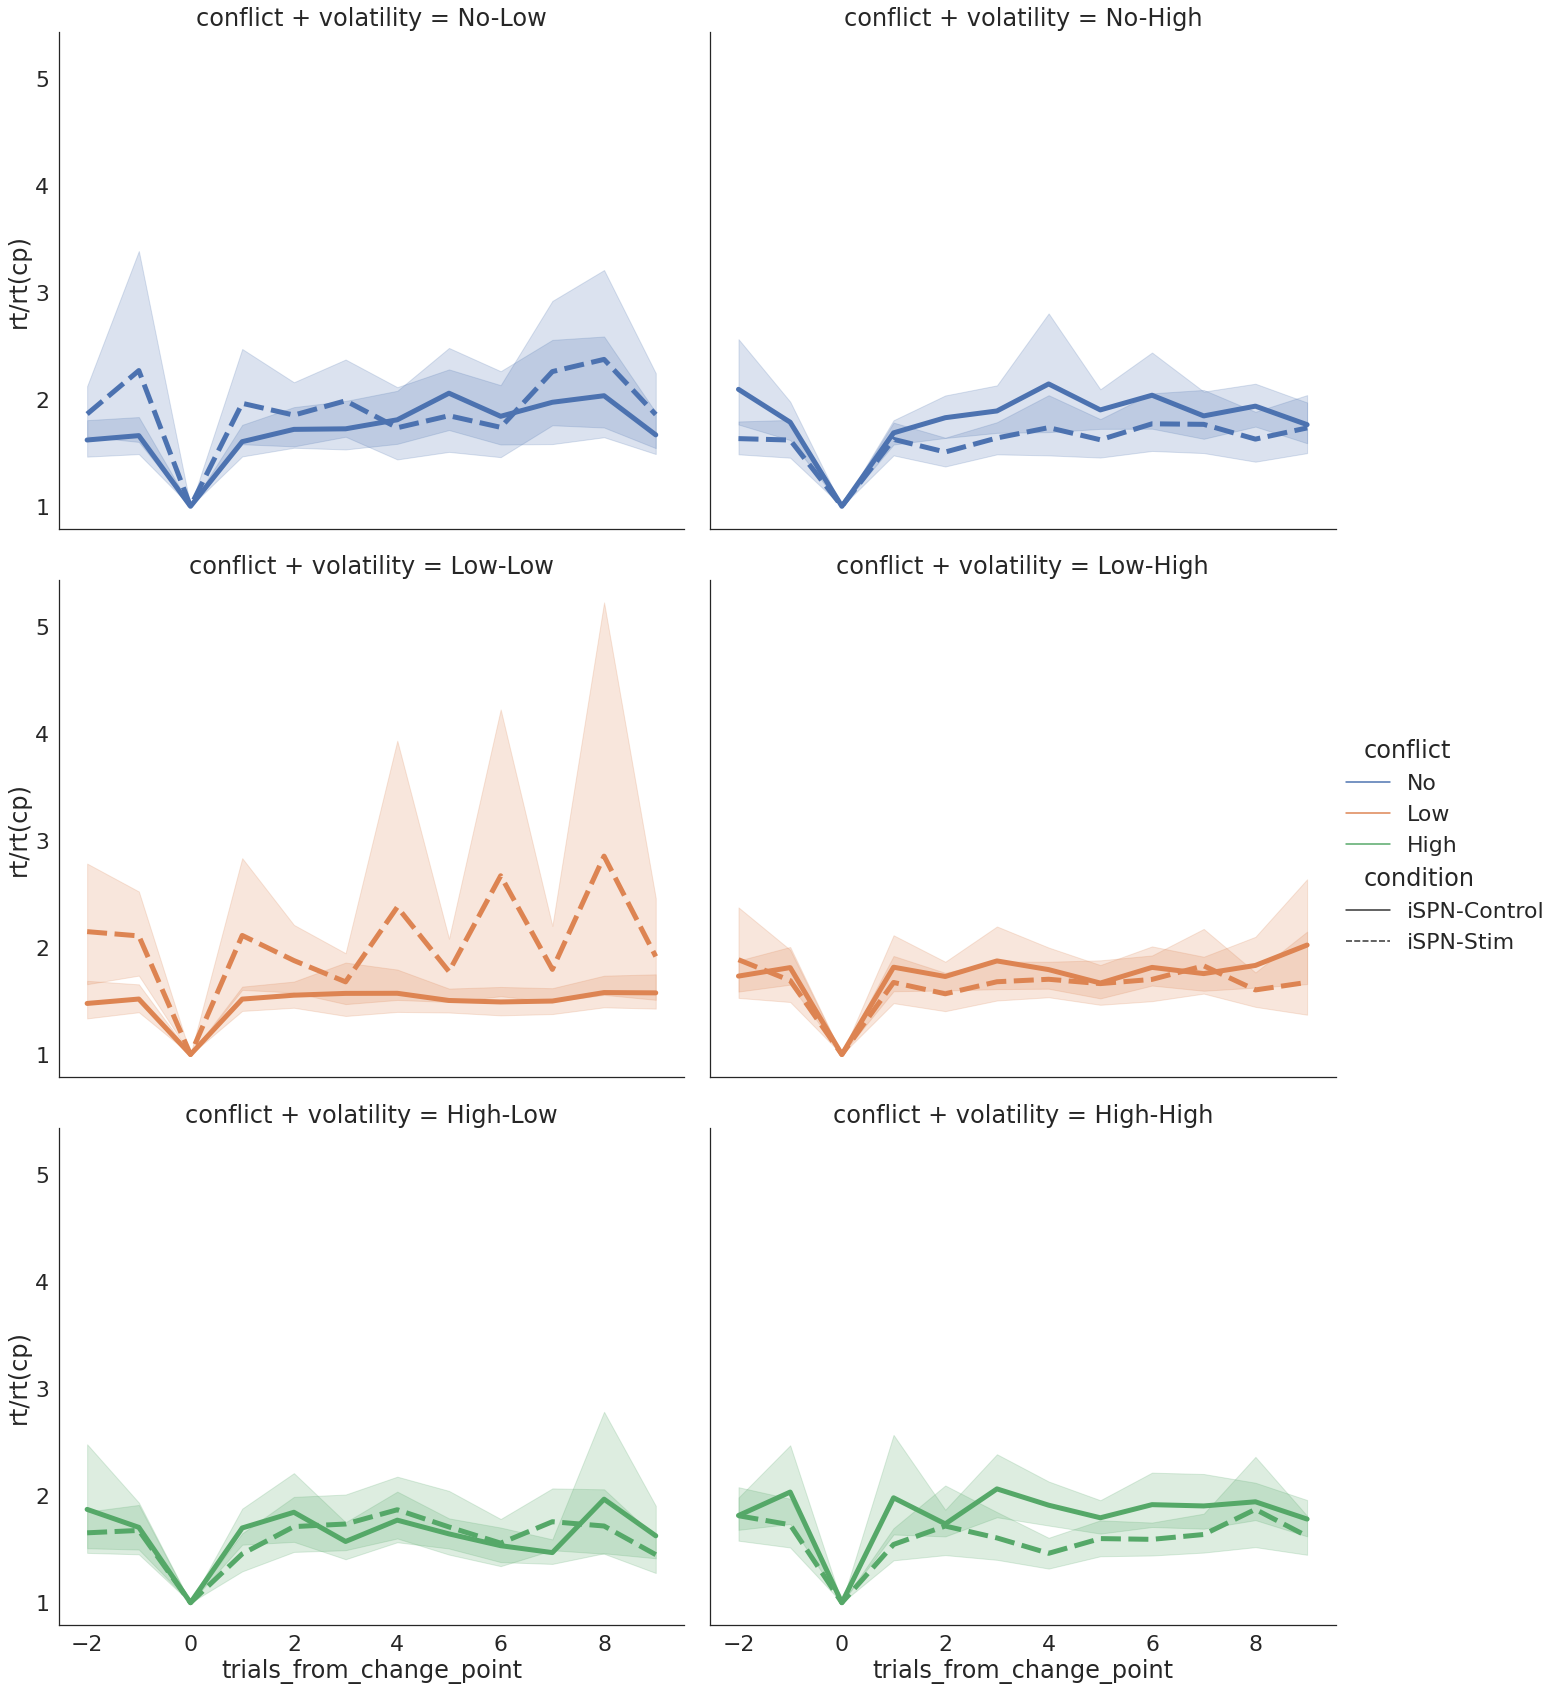

In [250]:
sns.set(font_scale=2)
plt.rcParams["figure.facecolor"] = "w"
sns.set_style(style='white')

g1 = sns.relplot(x="trials_from_change_point",y="rt/rt(cp)",hue="conflict",col="conflict + volatility",style="condition",data=block_change_aligned_df_avg_corrected.loc[block_change_aligned_df_avg_corrected["condition"].str.contains("iSPN")],kind='line',height=8,aspect=1.2,lw=5.0,hue_order=["No","Low","High"],style_order=["iSPN-Control","iSPN-Stim"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2)
for ax in g1.axes:
    vol = ax.get_title().split(' = ')[1]
    df = grp[1].loc[grp[1]["volatility"]==vol]
#     for x in ax.get_xticklabels():
#         x.set_fontsize(15)
#     for x in ax.get_yticklabels():
#         x.set_fontsize(15)
g1.fig.savefig(fig_target_dir+"aligned_rts_zscored"+"_ipsn_avg_corrected_all.png")

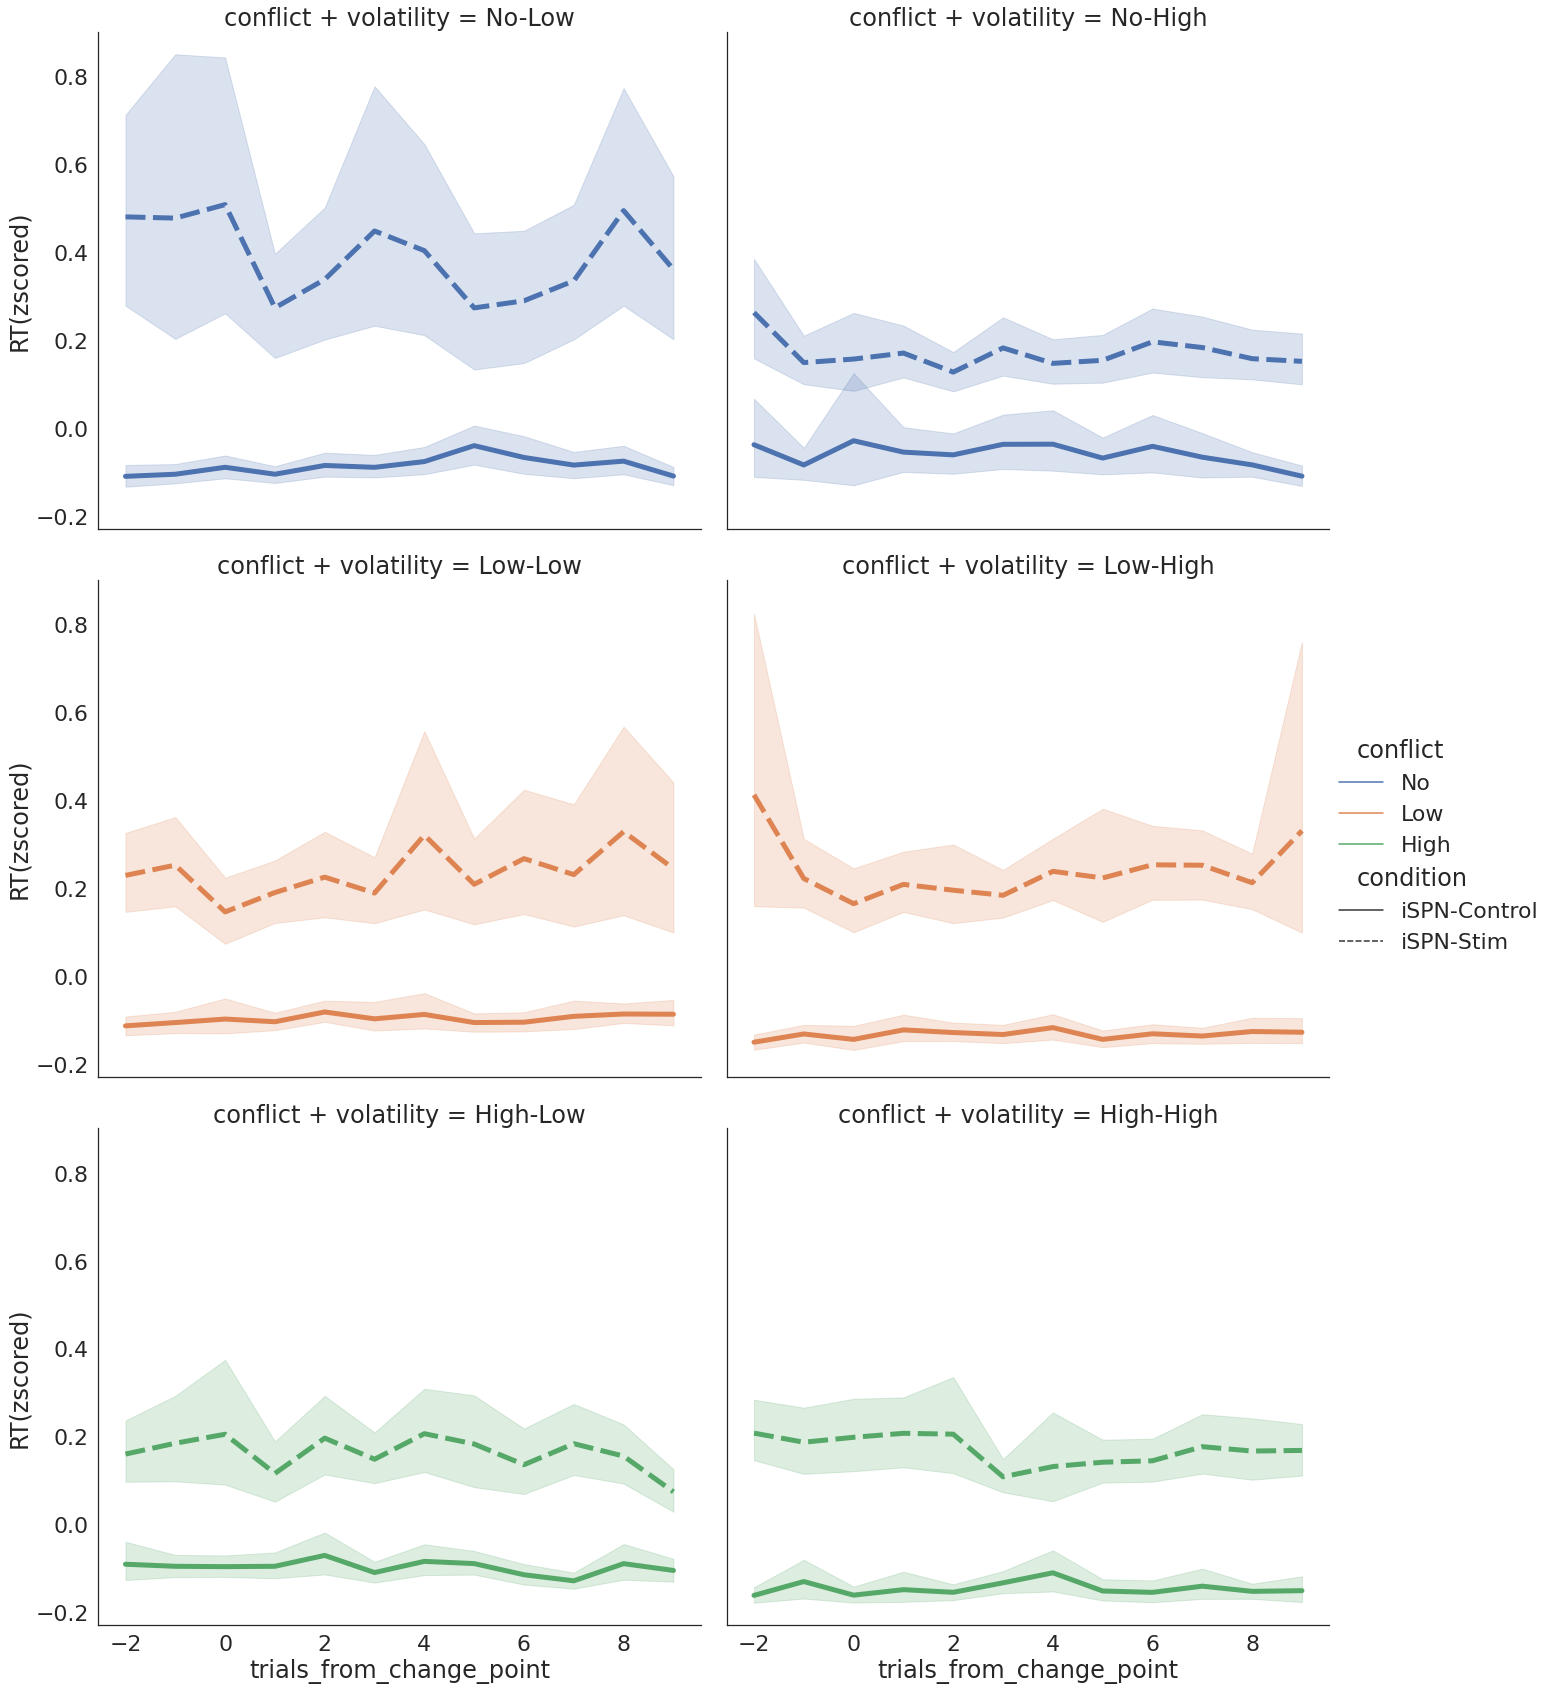

In [247]:
sns.set(font_scale=2)
plt.rcParams["figure.facecolor"] = "w"
sns.set_style(style='white')

g1 = sns.relplot(x="trials_from_change_point",y="RT(zscored)",hue="conflict",col="conflict + volatility",style="condition",data=rt_zscored.loc[rt_zscored["condition"].str.contains("iSPN")],kind='line',height=8,aspect=1.2,lw=5.0,hue_order=["No","Low","High"],style_order=["iSPN-Control","iSPN-Stim"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2)
for ax in g1.axes:
    vol = ax.get_title().split(' = ')[1]
    df = grp[1].loc[grp[1]["volatility"]==vol]
#     for x in ax.get_xticklabels():
#         x.set_fontsize(15)
#     for x in ax.get_yticklabels():
#         x.set_fontsize(15)
# g1.fig.savefig(fig_target_dir+"aligned_rts_zscored"+"_ipsn_avg_corrected_all.png")

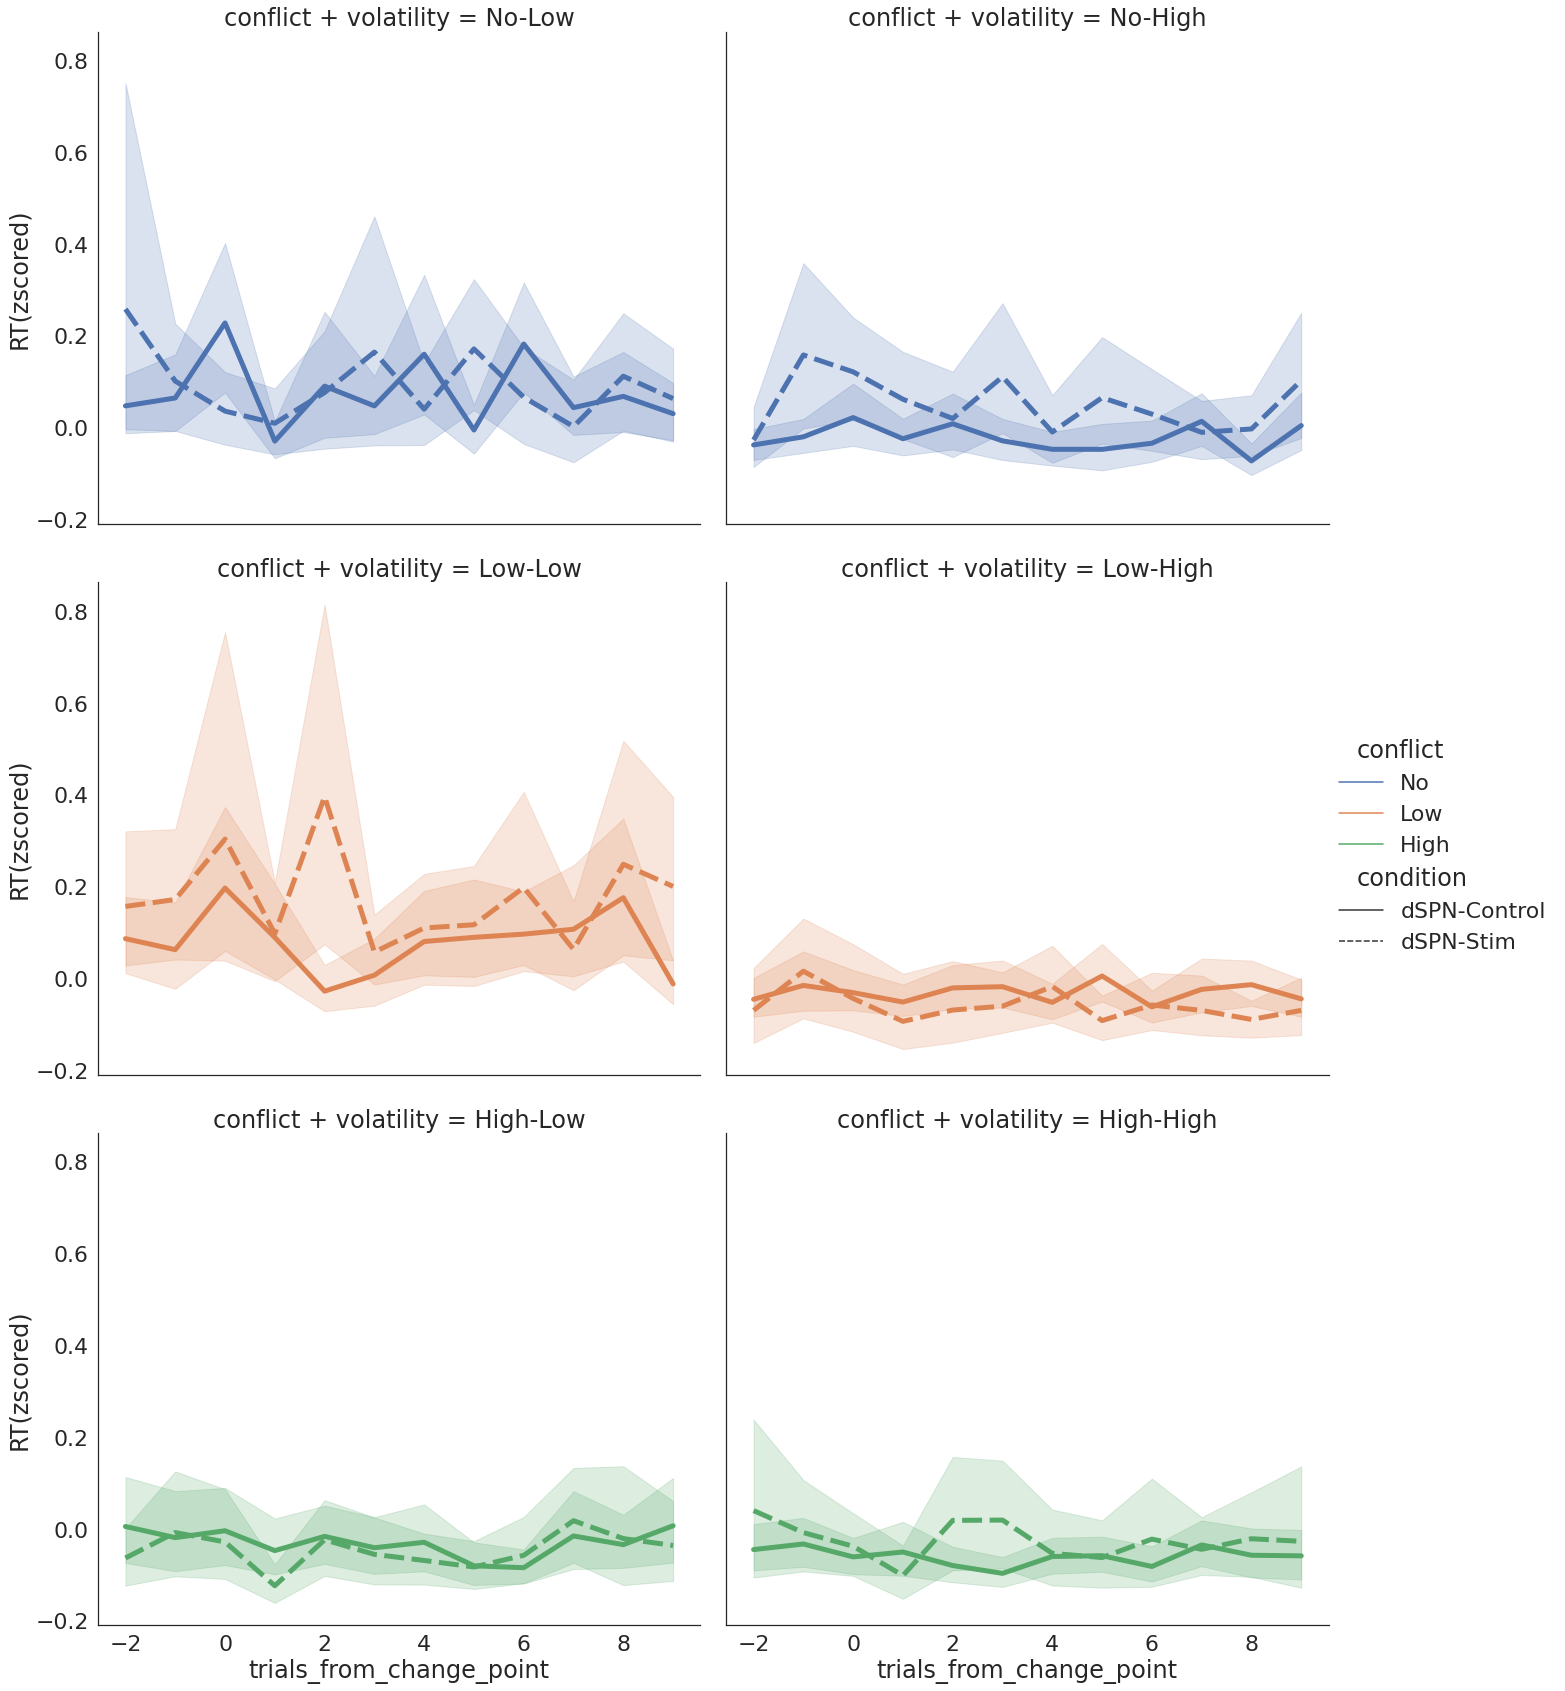

In [249]:
sns.set(font_scale=2)
plt.rcParams["figure.facecolor"] = "w"
sns.set_style(style='white')

g1 = sns.relplot(x="trials_from_change_point",y="RT(zscored)",hue="conflict",col="conflict + volatility",style="condition",data=rt_zscored.loc[rt_zscored["condition"].str.contains("dSPN")],kind='line',height=8,aspect=1.2,lw=5.0,hue_order=["No","Low","High"],style_order=["dSPN-Control","dSPN-Stim"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2)
for ax in g1.axes:
    vol = ax.get_title().split(' = ')[1]
    df = grp[1].loc[grp[1]["volatility"]==vol]


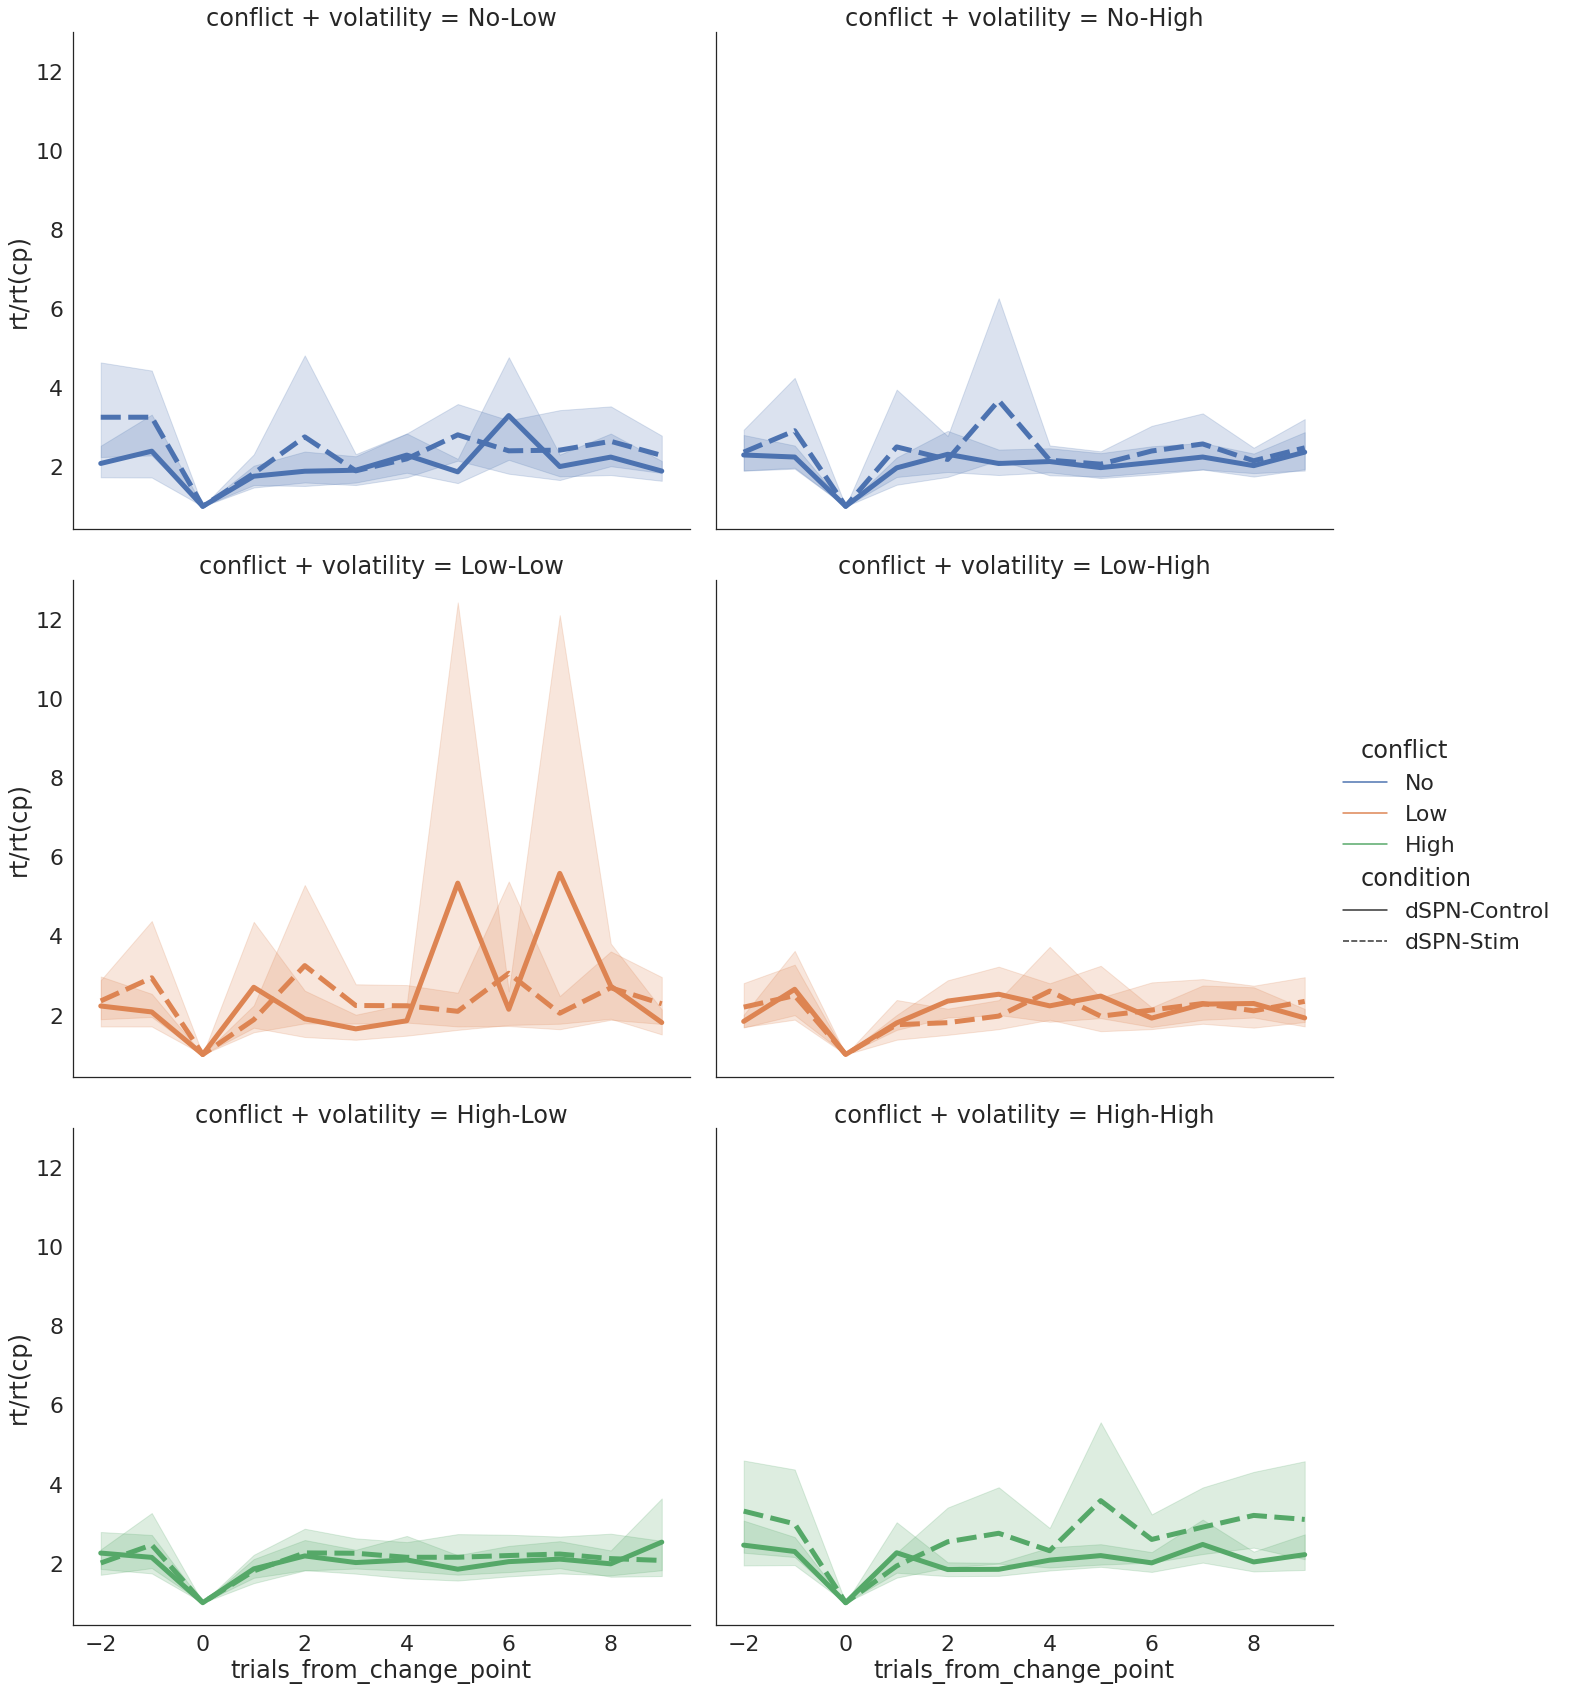

In [221]:
sns.set(font_scale=2)
plt.rcParams["figure.facecolor"] = "w"
sns.set_style(style='white')

g1 = sns.relplot(x="trials_from_change_point",y="rt/rt(cp)",hue="conflict",col="conflict + volatility",style="condition",data=block_change_aligned_df_avg_corrected.loc[block_change_aligned_df_avg_corrected["condition"].str.contains("dSPN")],kind='line',height=8,aspect=1.2,lw=5.0,hue_order=["No","Low","High"],style_order=["dSPN-Control","dSPN-Stim"],col_order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],palette='deep',col_wrap=2)
for ax in g1.axes:
    vol = ax.get_title().split(' = ')[1]
    df = grp[1].loc[grp[1]["volatility"]==vol]
#     for x in ax.get_xticklabels():
#         x.set_fontsize(15)
#     for x in ax.get_yticklabels():
#         x.set_fontsize(15)
g1.fig.savefig(fig_target_dir+"aligned_rts_zscored"+"_dpsn_avg_corrected_all.png")

In [89]:
ax.collections[0].get_datalim

<bound method Collection.get_datalim of <matplotlib.collections.PathCollection object at 0x7f3281a58610>>

In [37]:
combs

[('No-Low', 'No-High'),
 ('No-Low', 'Low-Low'),
 ('No-Low', 'Low-High'),
 ('No-Low', 'High-Low'),
 ('No-Low', 'High-High'),
 ('No-High', 'Low-Low'),
 ('No-High', 'Low-High'),
 ('No-High', 'High-Low'),
 ('No-High', 'High-High'),
 ('Low-Low', 'Low-High'),
 ('Low-Low', 'High-Low'),
 ('Low-Low', 'High-High'),
 ('Low-High', 'High-Low'),
 ('Low-High', 'High-High'),
 ('High-Low', 'High-High')]

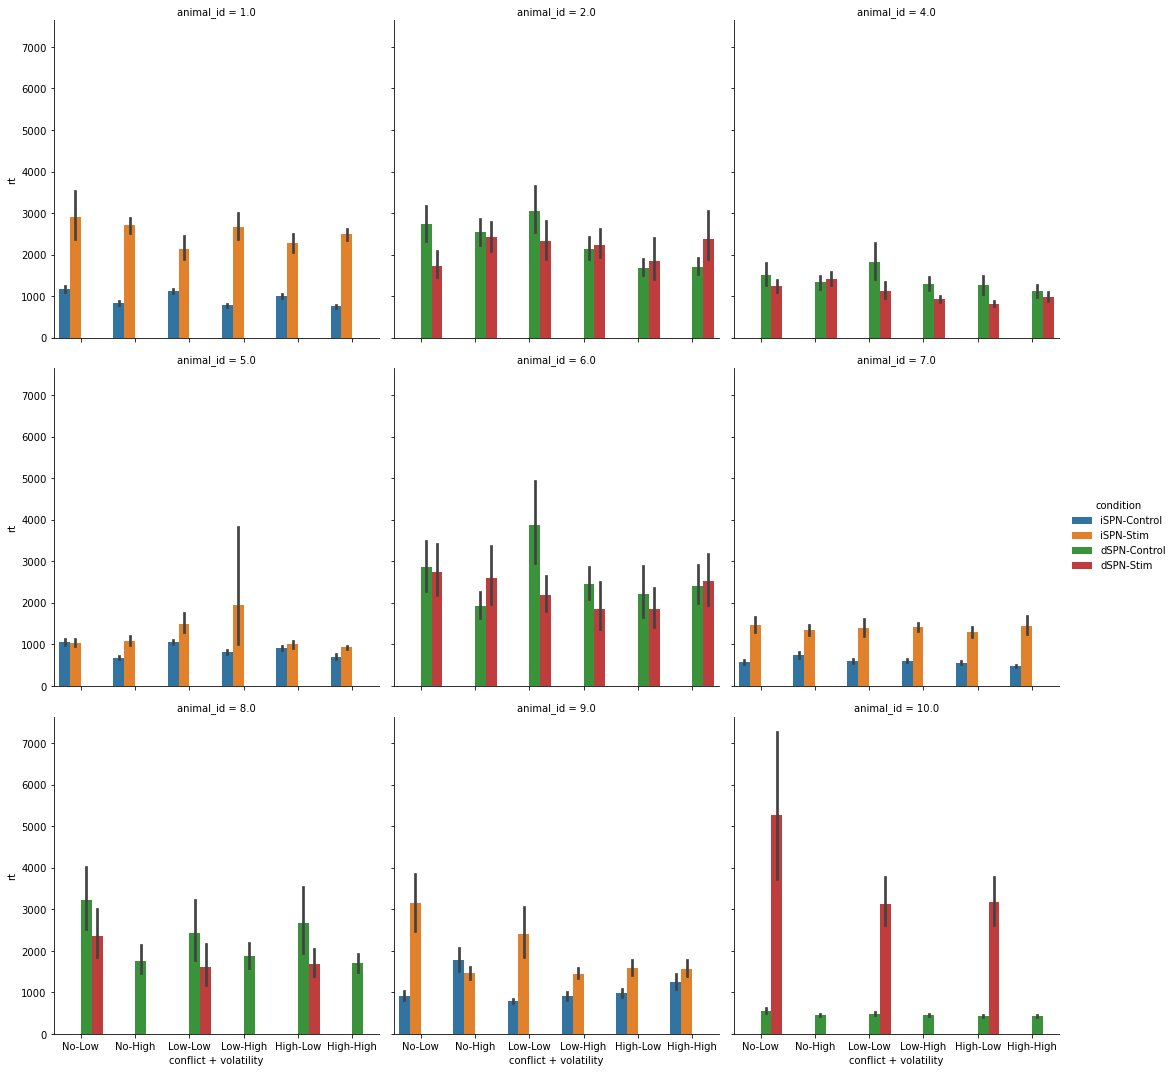

In [7]:
g1 = sns.catplot(x="conflict + volatility",y="rt",data=block_change_aligned_df.loc[block_change_aligned_df["trials_from_change_point"]>2],hue="condition",col="animal_id",kind='bar',order=["No-Low","No-High","Low-Low","Low-High","High-Low","High-High"],hue_order=["iSPN-Control","iSPN-Stim","dSPN-Control", "dSPN-Stim"],palette='tab10',col_wrap=3)

In [23]:
df

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, Unnamed: 0.1.1, r_t0, r_t1, cp, epoch_number, reward_p_t0, session, conflict, volatility, condition, p_id_solution, action_history, chosen_action, trial_num, animal_id, optimal, rt, block_num, cpp, ideal_B, b_t0, b_t1, MC, learning_rate, H(hazard_rate), sigma_estimated, u_val, n_val, block_change, trials_from_change_point, block_change_type, block_num_change, nuclei, experiment_type, experiment_type1, conflict + volatility, response]
Index: []

[0 rows x 39 columns]

In [30]:
ispn_pairs

[(('No-Low', 'i'), ('No-High', 'S')),
 (('No-Low', 'i'), ('Low-Low', 'S')),
 (('No-Low', 'i'), ('Low-High', 'S')),
 (('No-Low', 'i'), ('High-Low', 'S')),
 (('No-Low', 'i'), ('High-High', 'S')),
 (('No-High', 'i'), ('Low-Low', 'S')),
 (('No-High', 'i'), ('Low-High', 'S')),
 (('No-High', 'i'), ('High-Low', 'S')),
 (('No-High', 'i'), ('High-High', 'S')),
 (('Low-Low', 'i'), ('Low-High', 'S')),
 (('Low-Low', 'i'), ('High-Low', 'S')),
 (('Low-Low', 'i'), ('High-High', 'S')),
 (('Low-High', 'i'), ('High-Low', 'S')),
 (('Low-High', 'i'), ('High-High', 'S')),
 (('High-Low', 'i'), ('High-High', 'S'))]

In [24]:
an

'1.0'

In [18]:
combs

[('No-Low', 'No-High'),
 ('No-Low', 'Low-Low'),
 ('No-Low', 'Low-High'),
 ('No-Low', 'High-Low'),
 ('No-Low', 'High-High'),
 ('No-High', 'Low-Low'),
 ('No-High', 'Low-High'),
 ('No-High', 'High-Low'),
 ('No-High', 'High-High'),
 ('Low-Low', 'Low-High'),
 ('Low-Low', 'High-Low'),
 ('Low-Low', 'High-High'),
 ('Low-High', 'High-Low'),
 ('Low-High', 'High-High'),
 ('High-Low', 'High-High')]

In [27]:
data.animal_id

5          1.0
6          1.0
7          1.0
8          1.0
9          1.0
          ... 
178585    10.0
178586    10.0
178587    10.0
178588    10.0
178589    10.0
Name: animal_id, Length: 103306, dtype: float64